Modulo 2

In [1]:
#Misc
import os
import pickle
import importlib
import warnings
from tqdm import tqdm

#Data
import pandas as pd
import numpy as np


# Visualización
import cufflinks as cf
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones
warnings.filterwarnings("ignore")
plt.style.use('seaborn-white')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
cf.set_config_file(theme='white',dimensions=(650,450))
cf.go_offline()

In [2]:
# Scripts personales
sys.path.insert(1, '../../Datasets/')

# String
import StringUtils 
importlib.reload(StringUtils)

import PlotUtils 
importlib.reload(PlotUtils)

import SupervisedUtils 
importlib.reload(SupervisedUtils)

<module 'SupervisedUtils' from 'c:\\Users\\JesúsAdolfoValenciaM\\Diplomado-en-ciencia-de-datos\\Proyecto\\Modulo 5\\M2\\../../Datasets\\SupervisedUtils.py'>

In [3]:
def save_object(obj,name):
  with open(name + '.pkl', 'wb') as file:
    pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

def load_object(name):
    with open(name, 'rb') as file:
        return(pickle.load(file))

## Base módulo 1

In [4]:
TMDb = pd.read_feather('../M1/DBM1')
TMDb.head(2)

id                            genres original_language  \
0  610150  Animation-Science Fiction-Action                ja   
1  616037          Action-Adventure-Fantasy                en   

                                            overview  popularity    year  \
0  The Red Ribbon Army an evil organization that ...    7294.015  2022.0   
1  After his retirement is interrupted by Gorr th...    5207.555  2022.0   

   month   day       budget      revenue  runtime    status  \
0    6.0  11.0          0.0   68759433.0     99.0  Released   
1    7.0   6.0  250000000.0  746900000.0    119.0  Released   

                                   tagline  vote_average  vote_count  \
0  A super awakening and calamity is born.         7.330       253.0   
1                 The one is not the only.         6.766      2167.0   

                                            keywords  \
0  android-sequel-attack-based on manga-fighting-...   
1  ex-girlfriend-hero-greek mythology-sequel-supe...   

                        poster_path                     backdrop_path  
0  /rugyJdeoJm7cSJL1q4jBpTNbxyU.jpg  /ugS5FVfCI3RV0ZwZtBV3HAV75OX.jpg  
1  /pIkRyD18kl4FhoCNQuWxWu5cBLM.jpg  /vvObT0eIWGlArLQx3K5wZ0uT812.jpg

## Generación de variables

In [5]:
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
print(movies.shape)


(22880, 13)


In [6]:
movies.isna().sum().to_frame().T

id  genres  original_language  overview  popularity  year  month  budget  \
0   0       0                  0         0           0   204    204       0   

   runtime  tagline  vote_average  vote_count  keywords  
0       48     8550             0           0      5480

In [7]:
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

### Variable objetivo

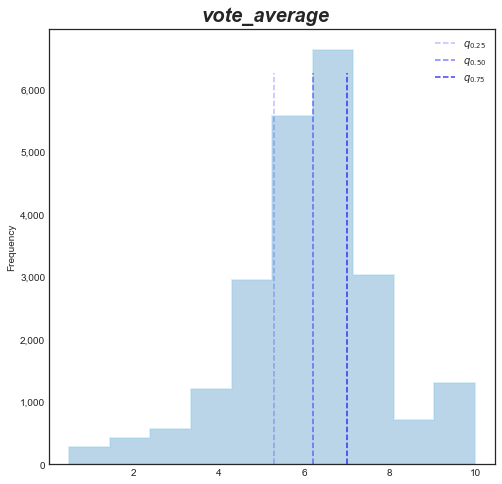

In [8]:
PlotUtils.hist(movies,'vote_average')

In [9]:
# movies['y']=pd.cut(movies['vote_average'],2)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

In [10]:
movies['y'].value_counts()

Malo     13633
Buena     9004
Name: y, dtype: int64

In [11]:
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])

### Variables independientes

In [16]:
movies.columns

Index(['id', 'genres', 'original_language', 'overview', 'popularity', 'year',
       'month', 'budget', 'runtime', 'tagline', 'vote_average', 'vote_count',
       'keywords', 'y'],
      dtype='object')

In [17]:
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X.head(2)

genres original_language  \
0  Action-Adventure-Fantasy                en   
1           Thriller-Action                en   

                                            overview    year  month  \
0  After his retirement is interrupted by Gorr th...  2022.0    7.0   
1  When danger threatens her camp the fierce and ...  2022.0    8.0   

        budget  runtime                               tagline  \
0  250000000.0    119.0              The one is not the only.   
1   65000000.0    100.0  They hunt to live. It lives to hunt.   

                                            keywords  
0  ex-girlfriend-hero-greek mythology-sequel-supe...  
1  hunter-alien life-form-prequel-alien-native am...

In [18]:
X.isna().sum().to_frame().T

genres  original_language  overview  year  month  budget  runtime  tagline  \
0       0                  0         0     0      0       0        0     8441   

   keywords  
0      5347

### Particion de los datos

In [19]:
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

## Procesamiento de variables independientes

### Variables categoricas

In [20]:
counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

X_train.head(2)

original_language                                           overview  \
19080                kn  Raghava is a fun-loving youngster who enjoys p...   
11196                en  Dr. Samantha Goodman is a beautiful young psyc...   

         year  month    budget  runtime tagline  \
19080  2012.0    9.0  550000.0    165.0    None   
11196  2005.0    3.0  500000.0     80.0    None   

                                                keywords  genre_action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_comedy  genre_drama  genre_horror  genre_otros  genre_romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_thriller  
19080               0  
11196               1

In [21]:

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])
X_test.head(2)

original_language                                           overview  \
11460                en  In the countryside the boy Alan and his friend...   
18446                en  A pansexual polyamorous trio kidnap a 'pray-th...   

         year  month     budget  runtime tagline  \
11460  2008.0    7.0  1500000.0      0.0    None   
18446  2019.0    5.0    27000.0     19.0    None   

                                    keywords  genre_action  genre_comedy  \
11460  snake-voodoo-giant snake-giant animal             0             0   
18446                                   None             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  
11460            0             1            2              0               0  
18446            0             1            0              0               1

In [22]:
counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])
X_train.head(2)

overview    year  month  \
19080  Raghava is a fun-loving youngster who enjoys p...  2012.0    9.0   
11196  Dr. Samantha Goodman is a beautiful young psyc...  2005.0    3.0   

         budget  runtime tagline  \
19080  550000.0    165.0    None   
11196  500000.0     80.0    None   

                                                keywords  genre_action  \
19080                                               None             0   
11196  canada-winter-hostage-olympic games-cabin-psyc...             0   

       genre_comedy  genre_drama  genre_horror  genre_otros  genre_romance  \
19080             1            0             1            0              0   
11196             0            0             1            1              0   

       genre_thriller  original_language_OTROS  original_language_en  
19080               0                        1                     0  
11196               1                        0                     1

In [23]:
X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])
X_test.head(2)

overview    year  month  \
11460  In the countryside the boy Alan and his friend...  2008.0    7.0   
18446  A pansexual polyamorous trio kidnap a 'pray-th...  2019.0    5.0   

          budget  runtime tagline                               keywords  \
11460  1500000.0      0.0    None  snake-voodoo-giant snake-giant animal   
18446    27000.0     19.0    None                                   None   

       genre_action  genre_comedy  genre_drama  genre_horror  genre_otros  \
11460             0             0            0             1            2   
18446             0             1            0             1            0   

       genre_romance  genre_thriller  original_language_OTROS  \
11460              0               0                        0   
18446              0               1                        0   

       original_language_en  
11460                     1  
18446                     1

### Variables de tipo caracter

In [24]:
engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw


In [25]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_train['overview_clean']=StringUtils.remove_stopwords(X_train['overview_clean'],engstopwords)
X_train['overview_clean']=StringUtils.remove_accents(X_train['overview_clean'])

X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])
X_test['overview_clean']=StringUtils.remove_stopwords(X_test['overview_clean'],engstopwords)
X_test['overview_clean']=StringUtils.remove_accents(X_test['overview_clean'])

In [26]:
overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])

X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

In [27]:
keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))

X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

In [28]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [29]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [30]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [31]:
X_train.head(2)

year  month    budget  runtime  genre_action  genre_comedy  \
19080  2012.0    9.0  550000.0    165.0             0             1   
11196  2005.0    3.0  500000.0     80.0             0             0   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0         0.0         0.0   
11196                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080         0.0         0.0         0.0         0.0    0.206135         0.0   
11196         0.0         0.0         0.0         0.0    0.000000         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080         0.0    0.219586          0.0          0.0          0.0   
11196         0.0    0.000000          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
19080          0.0          0.0          0.0     0.000000          0.0   
11196          0.0          0.0          0.0     0.473857          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
19080          0.0     0.000000          0.0          0.0     0.164739   
11196          0.0     0.358021          0.0          0.0     0.000000   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
19080     0.355682          0.0          0.0          0.0      0.21052   
11196     0.000000          0.0          0.0          0.0      0.00000   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
19080          0.0     0.189452          0.0     0.550907      0.20605   
11196          0.0     0.000000          0.0     0.000000      0.00000   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
19080          0.0     0.000000          0.0          0.0          0.0   
11196          0.0     0.482778          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
19080          0.0          0.0          0.0     0.215457          0.0   
11196          0.0          0.0          0.0     0.000000          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
19080          0.0          0.0     0.394267          0.0          0.0   
11196          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
19080          0.0          0.0          0.0     0.196711          0.0   
11196          0.0          0.0          0.0     0.421615          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
19080          0.0          0.0          0.0          0.0          0.0   
11196          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
19080     0.222513          0.0          0.0          0.0          0.0   
11196     0.000000          

In [32]:
X_test.head(2)

year  month     budget  runtime  genre_action  genre_comedy  \
11460  2008.0    7.0  1500000.0      0.0             0             0   
18446  2019.0    5.0    27000.0     19.0             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1         0.0         0.0   
18446                        0                     1         0.0         0.0   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460         0.0         0.0         0.0         0.0         0.0         0.0   
18446         0.0         0.0         0.0         0.0         0.0         0.0   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460    0.617602         0.0          0.0          0.0          0.0   
18446    0.000000         0.0          0.0          0.0          0.0   

       overview_13  overview_14  overview_15  overview_16  overview_17  \
11460          0.0          0.0     0.293119          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_18  overview_19  overview_20  overview_21  overview_22  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_23  overview_24  overview_25  overview_26  overview_27  \
11460          0.0          0.0     0.272503          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_28  overview_29  overview_30  overview_31  overview_32  \
11460     0.267763          0.0          0.0          0.0     0.290782   
18446     0.000000          0.0          0.0          0.0     0.000000   

       overview_33  overview_34  overview_35  overview_36  overview_37  \
11460     0.262136          0.0          0.0          0.0          0.0   
18446     0.000000          0.0          0.0          0.0          0.0   

       overview_38  overview_39  overview_40  overview_41  overview_42  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_43  overview_44  overview_45  overview_46  overview_47  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_48  overview_49  overview_50  overview_51  overview_52  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_53  overview_54  overview_55  overview_56  overview_57  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_58  overview_59  overview_60  overview_61  overview_62  \
11460          0.0          0.0     0.290573          0.0          0.0   
18446          0.0          0.0     0.000000          0.0          0.0   

       overview_63  overview_64  overview_65  overview_66  overview_67  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_68  overview_69  overview_70  overview_71  overview_72  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0          0.0          0.0          0.0          0.0   

       overview_73  overview_74  overview_75  overview_76  overview_77  \
11460          0.0          0.0          0.0          0.0          0.0   
18446          0.0       

### Escalamiento

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
sc = MinMaxScaler()
sc.fit(X_train)

MinMaxScaler()

In [35]:
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# Modelado

## Modelos ocupando vectorización

### Regresión logística

#### Modelo default

In [36]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [37]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.6725781003471126
Score en test: 0.6557714958775029


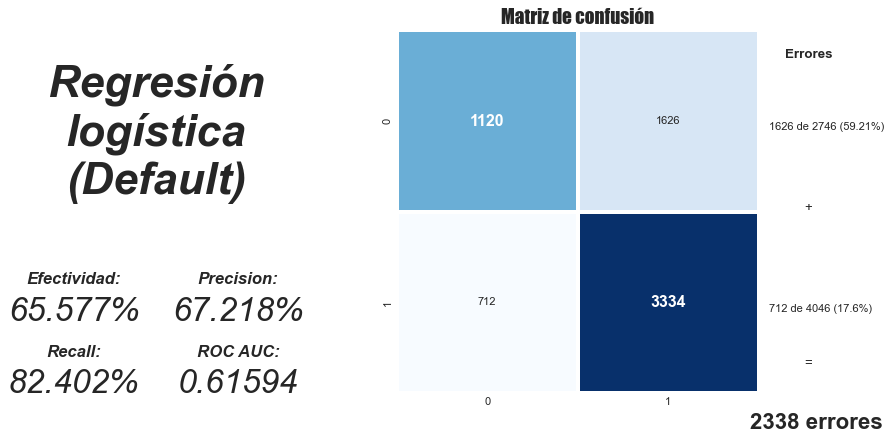

In [38]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

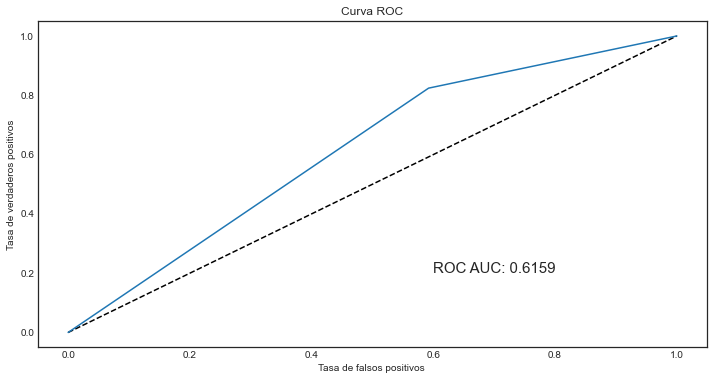

In [39]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [40]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [41]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [42]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

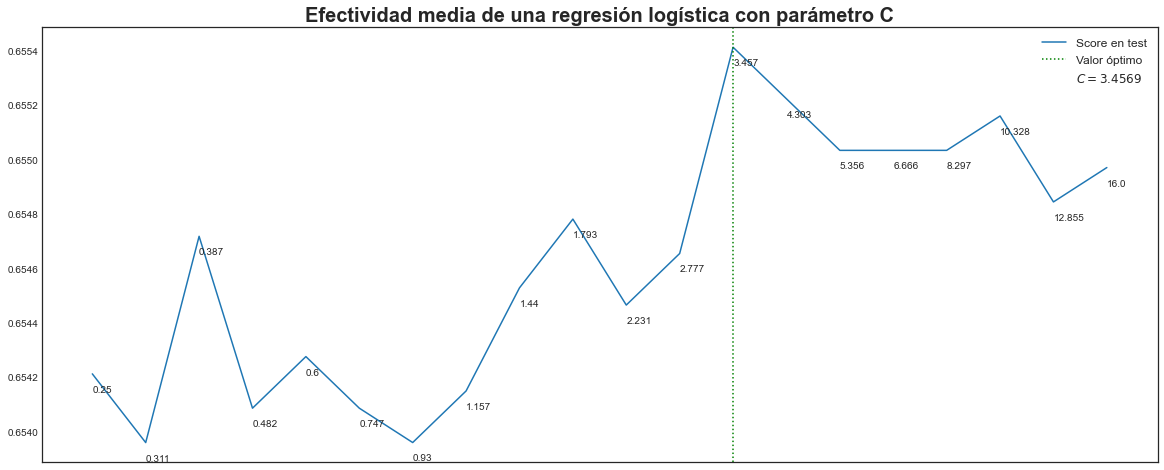

In [43]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [44]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=3.456887573126422, n_jobs=-1, random_state=12345)

In [45]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.6723887661722942
Score en test: 0.6528268551236749


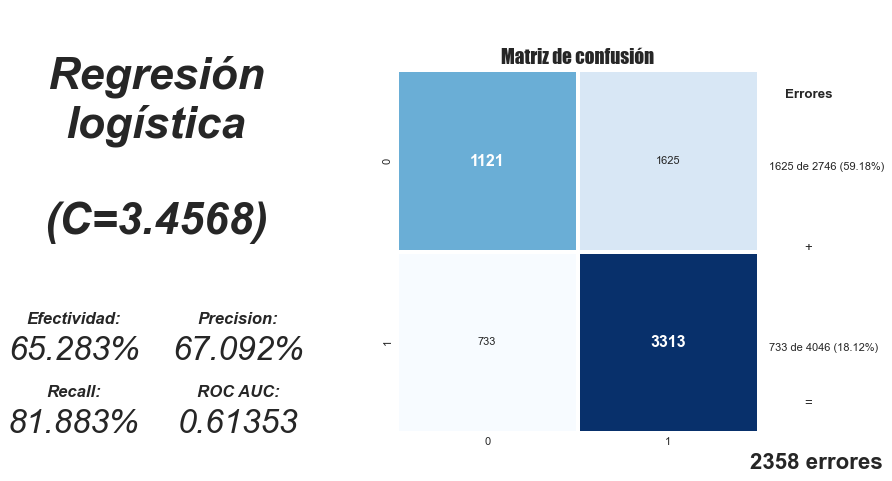

In [46]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=3.4568)',y_test,y_BestLogModel)

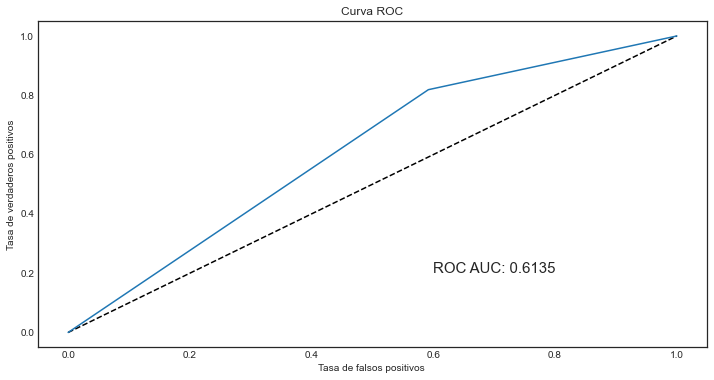

In [47]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [48]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [49]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.7563309776207303


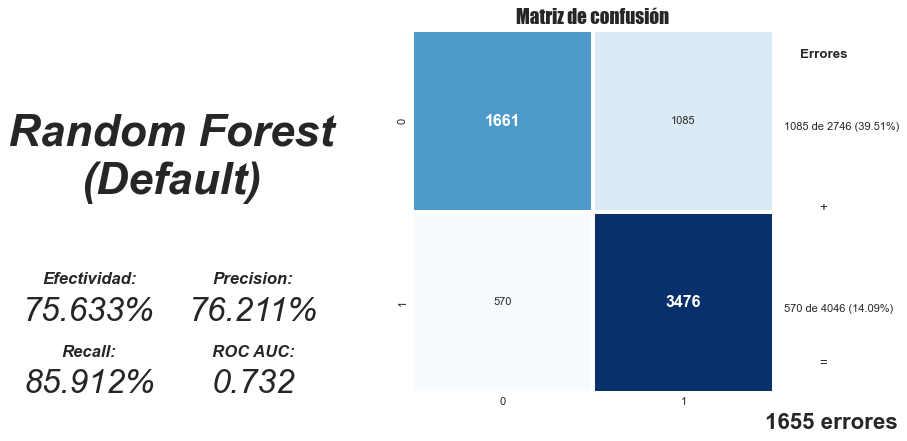

In [50]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

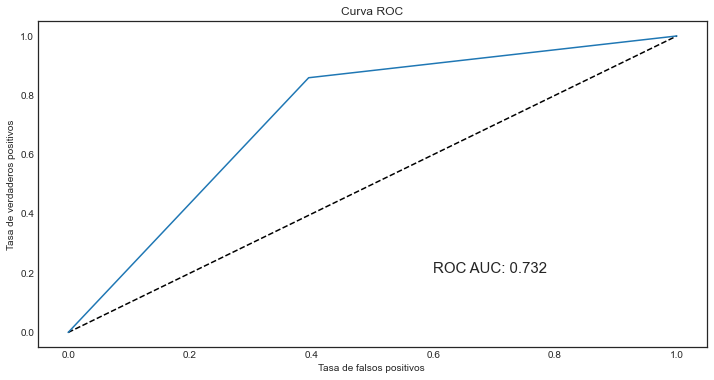

In [51]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [52]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [53]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [54]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.800) total time=   0.0s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.700) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [55]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [56]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

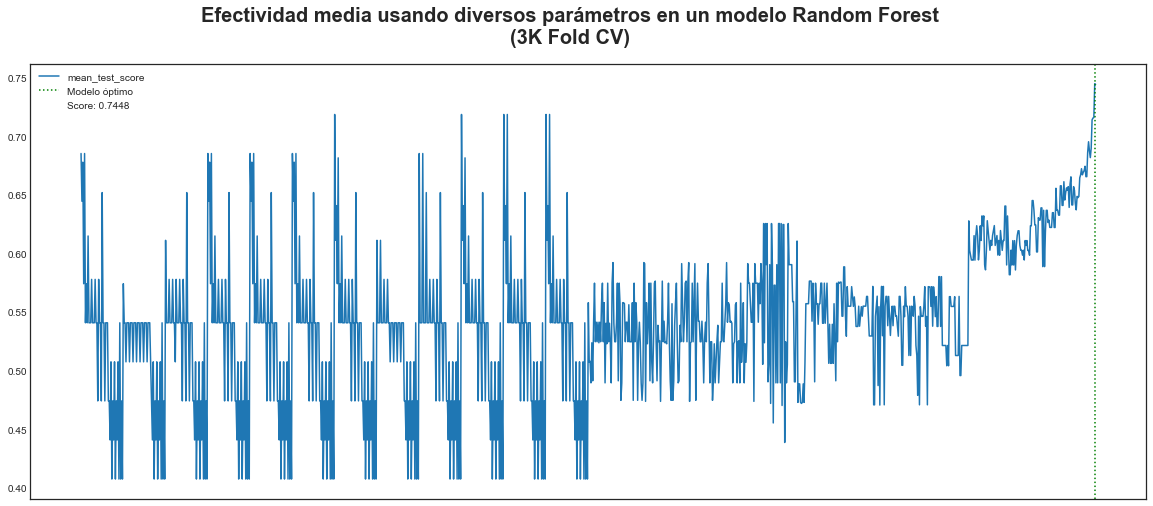

In [57]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [58]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                       1.063805
std_fit_time                                                        0.019363
mean_score_time                                                     0.131708
std_score_time                                                      0.017096
param_criterion                                                      entropy
param_max_depth                                                         None
param_min_samples_leaf                                                     1
param_min_samples_split                                                    4
param_n_estimators                                                       200
params                     {'criterion': 'entropy', 'max_depth': None, 'm...
split0_test_score                                                   0.747852

In [59]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133         entropy              50                      1   
1134            gini              50                      1   
1135         entropy              50                      1   
1136            gini              20                      1   
1137            gini              50                      1   
1138            gini            None                      1   
1139         entropy            None                      1   
1140         entropy            None                      1   
1141         entropy            None                      2   
1142            gini              20                      1   
1143         entropy              50                      1   
1144            gini            None                      1   
1145         entropy            None                      1   
1146            gini              20                      1   
1147         entropy            None                      1   
1148         entropy            None                      1   
1149         entropy            None                      1   
1150            gini            None                      1   
1151         entropy            None                      1   
1152            gini            None                      1   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                       2                100          1.000000   
1134                       6                200          0.995050   
1135                       2                200          1.000000   
1136                       4                200          0.957007   
1137                       4                200          0.998697   
1138                       4                200          0.999218   
1139                       2                200          1.000000   
1140                       4                200          0.999739   
1141                      10                100          0.959615   
1142                       6                200          0.951796   
1143                       2                200          1.000000   
1144                       4                200          0.998958   
1145                       2                200          1.000000   
1146                       4                200          0.939568   
1147                       4                200          0.999219   
1148                       2                200          1.000000   
1149                       4                200          0.998958   
1150                       4                200          0.998242   
1151                       4                200          0.999121   
1152                       4                200          0.998633   

      mean_test_score  
1133         0.648586  
1134         0.664410  
1135         0.667014  
1136         0.672225  
1137         0.667011  
1138         0.669096  
1139         0.670665  
1140         0.674310  
1141         0.665452  
1142         0.665448  
1143         0.686117  
1144         0.695234  
1145         0.687420  
1146         0.681689  
1147         0.689762  
1148         0.713895  
1149         0.715458  
1150         0.715849  
1151         0.744775  
1152         0.744123

#### Mejor modelo Random Forest

In [60]:
BestRFModel = SupervisedUtils.RandomForestClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=4,n_estimators=200,random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(min_samples_split=4, n_estimators=200, n_jobs=-1,
                       random_state=12345)

In [61]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 0.9987377721678763
Score en test: 0.7563309776207303


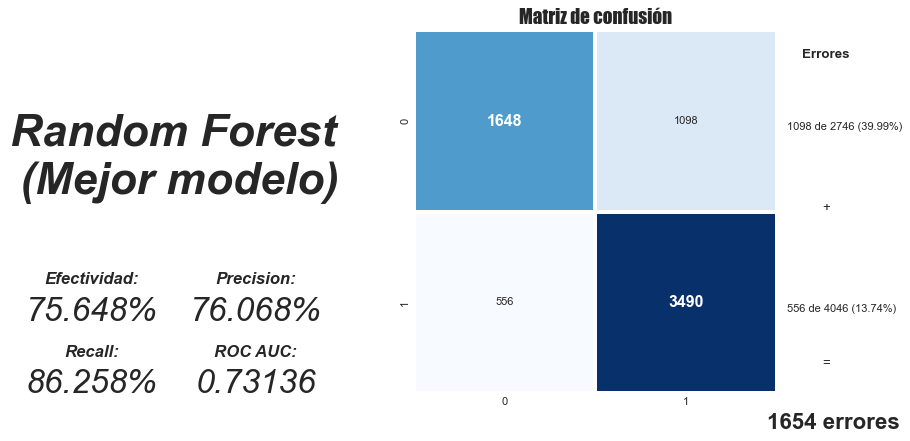

In [62]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

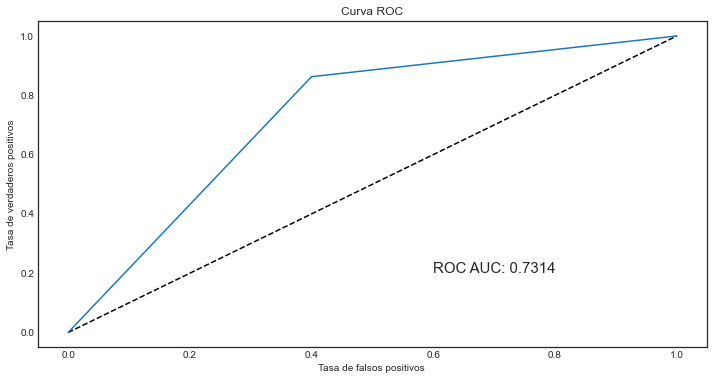

In [63]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [64]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [65]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.7558220258756706
Score en test: 0.607037691401649


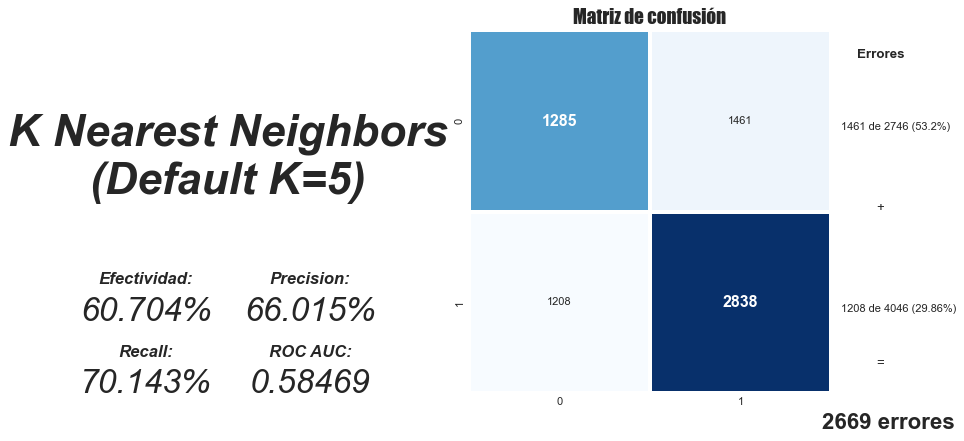

In [66]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

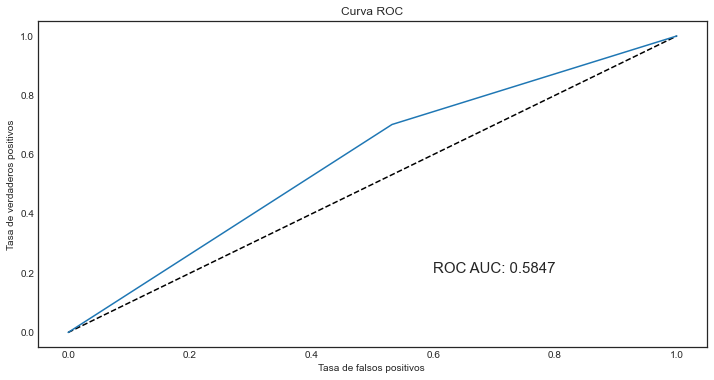

In [67]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [68]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [69]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [70]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.646, test=0.463) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.640, test=0.488) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.744, test=0.537) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [71]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [72]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

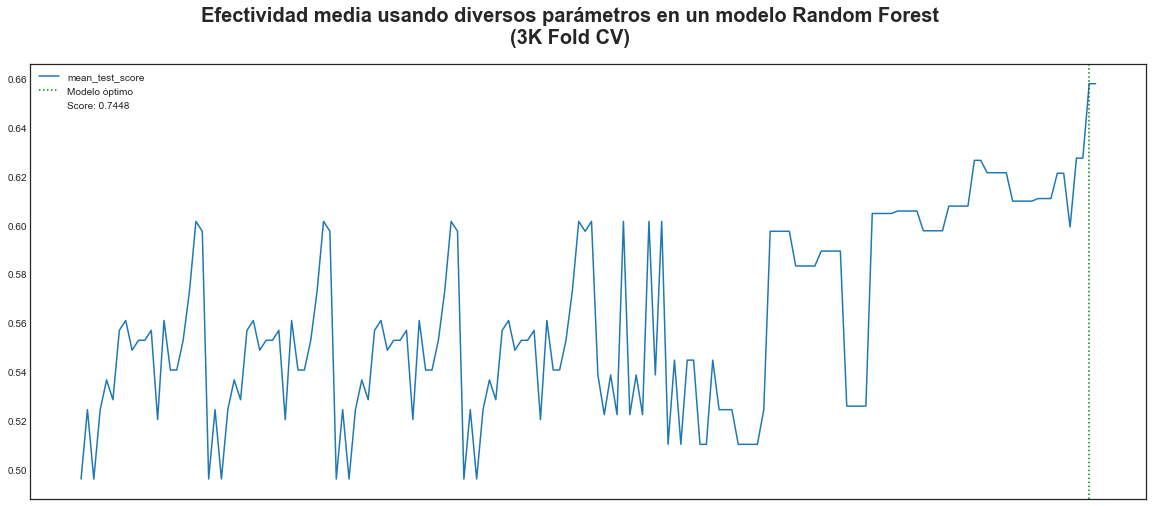

In [73]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [74]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                  0.023939
std_fit_time                                                   0.001411
mean_score_time                                                1.429975
std_score_time                                                 0.015047
param_leaf_size                                                      50
param_n_neighbors                                                    50
param_p                                                               2
param_weights                                                  distance
params                {'leaf_size': 50, 'n_neighbors': 50, 'p': 2, '...
split0_test_score                                              0.668058
split1_test_score                                              0.669197
split2_test_score                                              0

In [75]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140              50                50       2      distance          1.000000   
141              30                50       2      distance          1.000000   
142             100                50       2       uniform          0.646925   
143              10                50       2       uniform          0.646925   
144              50                50       2       uniform          0.646925   
145              30                50       2       uniform          0.646925   
146              10                50       1       uniform          0.662870   
147             100                50       1       uniform          0.662870   
148              30                50       1       uniform          0.662870   
149              50                50       1       uniform          0.662870   
150              10                50       2       uniform          0.642242   
151              50                50       2       uniform          0.642242   
152              30                50       2       uniform          0.642242   
153              50                50       2      distance          1.000000   
154              30                50       2      distance          1.000000   
155              30                50       2       uniform          0.619852   
156              50                50       2      distance          1.000000   
157              30                50       2      distance          1.000000   
158              50                50       2      distance          1.000000   
159              30                50       2      distance          1.000000   

     mean_test_score  
140         0.626646  
141         0.626646  
142         0.621581  
143         0.621581  
144         0.621581  
145         0.621581  
146         0.609929  
147         0.609929  
148         0.609929  
149         0.609929  
150         0.610985  
151         0.610985  
152         0.610985  
153         0.621362  
154         0.621362  
155         0.599342  
156         0.627563  
157         0.627563  
158         0.658103  
159         0.658103

#### Mejor modelo KNN

In [76]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50, weights='distance')
BestKNNModel

KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50,
                     weights='distance')

In [77]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 1.0
Score en test: 0.6709363957597173


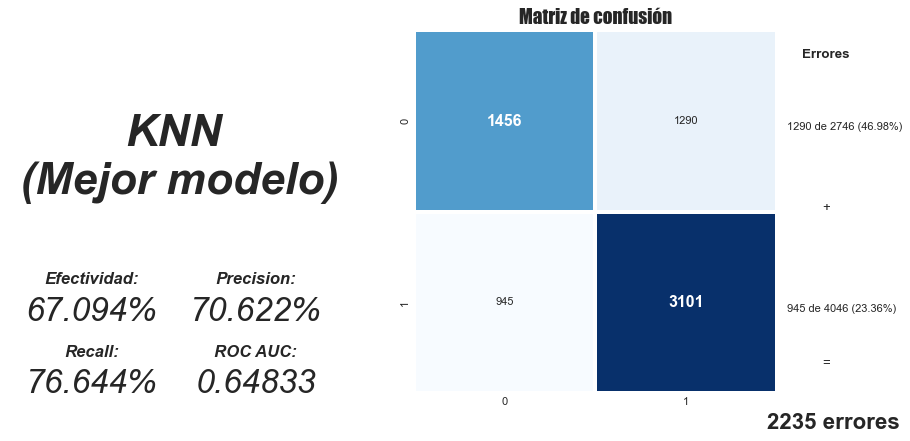

In [78]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

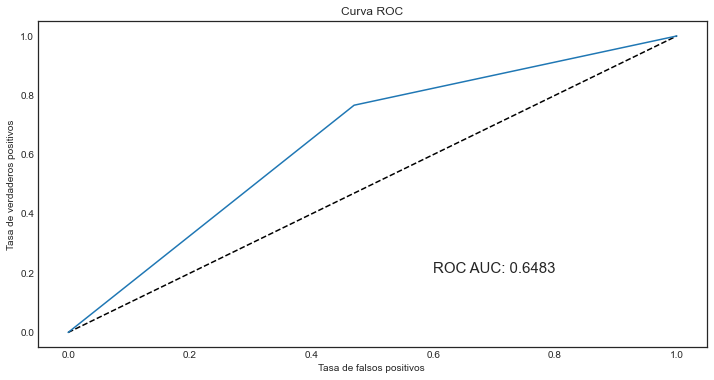

In [79]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [80]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    1                        1
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

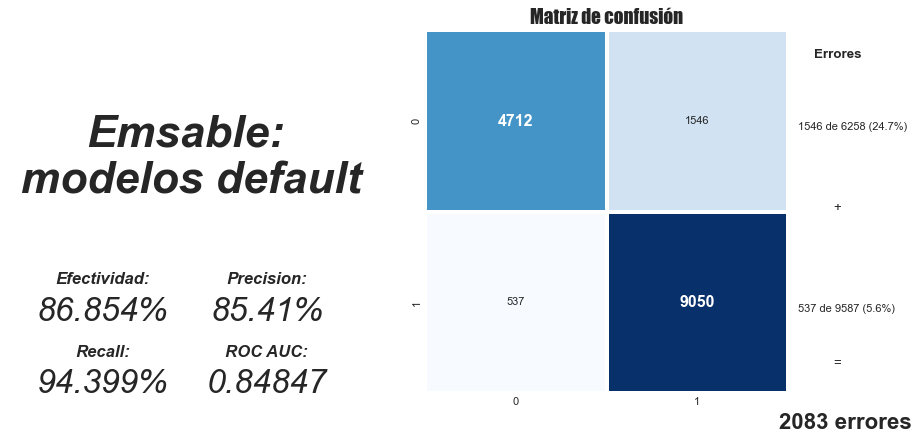

In [81]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [82]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    0                        0
8                    0              0    0                        0
9                    1              1    1                        1

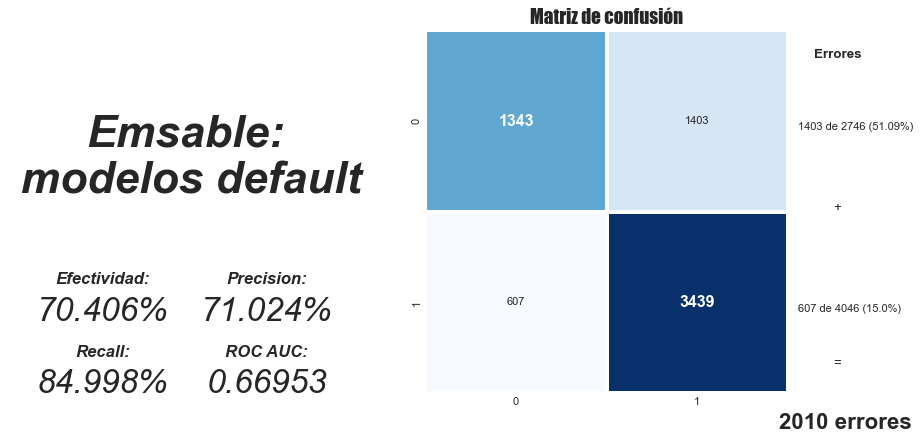

In [83]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [84]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    0              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    1              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

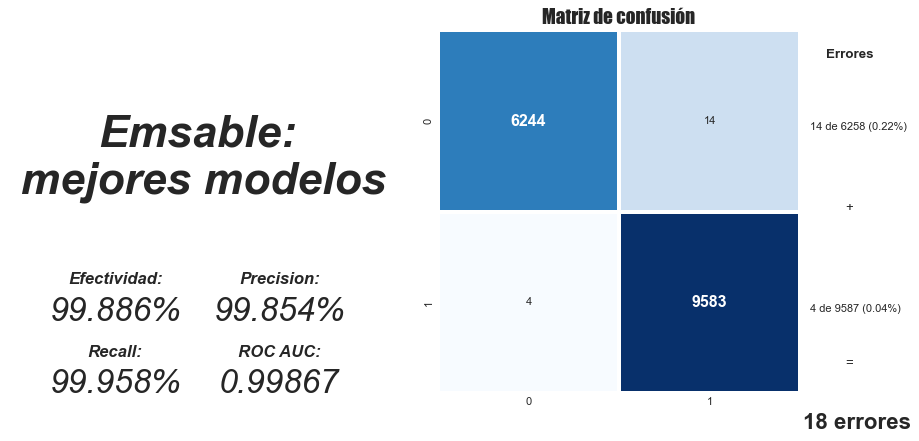

In [85]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [86]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    0                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              0    1                        1
4                    0              0    0                        0
5                    1              1    0                        1
6                    1              1    1                        1
7                    0              1    1                        1
8                    0              0    0                        0
9                    1              1    1                        1

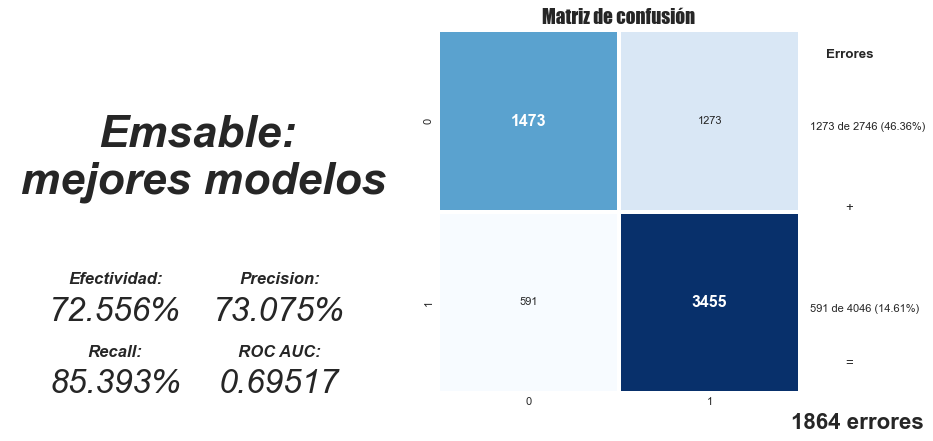

In [87]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [88]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [89]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                 0.655770        0.75633  0.607040   
Precision                   0.672180        0.76211  0.660150   
Recall                      0.824020        0.85912  0.701430   
ROC AUC - Score             0.615945        0.73200  0.584693   

                 Ensamble: Default  
Efectividad               0.704060  
Precision                 0.710240  
Recall                    0.849980  
ROC AUC - Score           0.669525

In [102]:
ModelMetricsDef_TFID=ModelMetricsDef
ModelMetricsDef_TFID.to_excel('ModelMetricsDef_TFID.xlsx')

In [91]:
# ModelMetricsDef = load_object('ModelMetricsDef_TFID.pkl')
# ModelMetricsDef_TFID=ModelMetricsDef

#### Métricas de modelos seleccionados

In [107]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_BestRFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [108]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                 0.652830       0.756480  0.670940   
Precision                   0.670920       0.760680  0.706220   
Recall                      0.818830       0.862580  0.766440   
ROC AUC - Score             0.613532       0.731363  0.648331   

                 Ensamble: Mejores modelos  
Efectividad                       0.725560  
Precision                         0.730750  
Recall                            0.853930  
ROC AUC - Score                   0.695173

In [109]:
ModelMetrics_TFID=ModelMetrics
ModelMetrics_TFID.to_excel('ModelMetrics_TFID.xlsx')

In [95]:
# ModelMetrics = load_object('ModelMetrics_TFID.pkl')
# ModelMetrics_TFID=ModelMetrics

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

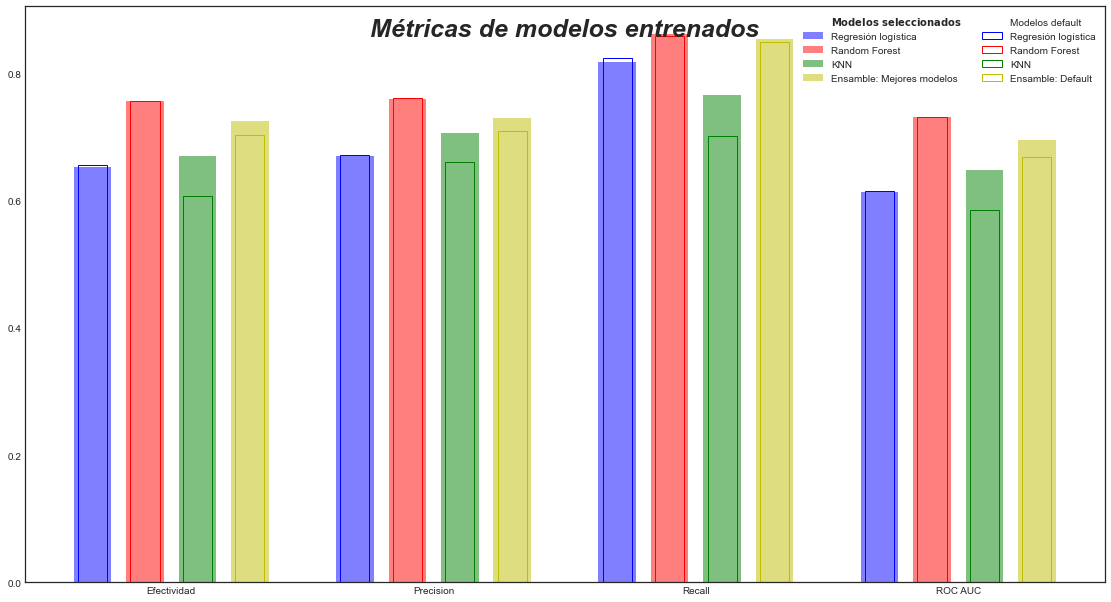

In [110]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [111]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [112]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [113]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [114]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                  0.652830      0.756480  0.670940   
Precision                    0.670920      0.760680  0.706220   
Recall                       0.818830      0.862580  0.766440   
ROC AUC - Score              0.613532      0.731363  0.648331   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.725560            0.655770       0.75633   
Precision                        0.730750            0.672180       0.76211   
Recall                           0.853930            0.824020       0.85912   
ROC AUC - Score                  0.695173            0.615945       0.73200   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.607040                  0.704060  
Precision        0.660150                  0.710240  
Recall           0.701430                  0.849980  
ROC AUC - Score  0.584693                  0.669525

## Modelos ocupando Doc2Vec

### Preprocesamiento

In [6]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [7]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)

movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)
le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]
X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)


counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw

In [8]:
X_train['overview_clean']=StringUtils.clean_re(X_train['overview'])
X_test['overview_clean']=StringUtils.clean_re(X_test['overview'])

overview_tags = [TaggedDocument(words = x.split(), tags = [y]) for x,y in zip(X_train['overview_clean'],y_train)]

print('Entrenando modelo d2v_overview')
d2v_overview = Doc2Vec(vector_size=100, min_count=1, epochs=10)
d2v_overview.build_vocab(overview_tags)
d2v_overview.train(overview_tags, total_examples=d2v_overview.corpus_count, epochs=d2v_overview.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(overview_tags):
    v = d2v_overview.infer_vector(t[0])
    auxlist.append(v)

X_overview_train=pd.DataFrame(auxlist)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['overview_clean']):
    v = d2v_overview.infer_vector(t.split())
    auxlist.append(v)
    
X_overview_test=pd.DataFrame(auxlist)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]
X_overview_test.index = X_test.index

Entrenando modelo d2v_overview
Creando matriz de entrenamiento


100%|██████████| 15845/15845 [00:11<00:00, 1434.24it/s]


Creando matriz de validacion


100%|██████████| 6792/6792 [00:04<00:00, 1444.93it/s]


In [9]:
keywords_tags = [TaggedDocument(words = x.split('-'), tags = [y]) for x,y in zip(X_train['keywords'].astype(str),y_train)]

print('Entrenando modelo d2v_keywords')
d2v_keywords = Doc2Vec(vector_size=100, min_count=1, epochs=10)
d2v_keywords.build_vocab(keywords_tags)
d2v_keywords.train(keywords_tags, total_examples=d2v_keywords.corpus_count, epochs=d2v_keywords.epochs)

print('Creando matriz de entrenamiento')

auxlist=list()

for t in tqdm(keywords_tags):
    v = d2v_keywords.infer_vector(t[0])
    auxlist.append(v)

X_keywords_train=pd.DataFrame(auxlist)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_train.index = X_train.index

print('Creando matriz de validacion')

auxlist=list()

for t in tqdm(X_test['keywords'].astype(str)):
    v = d2v_keywords.infer_vector(t.split('-'))
    auxlist.append(v)
    
X_keywords_test=pd.DataFrame(auxlist)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]
X_keywords_test.index = X_test.index

Entrenando modelo d2v_keywords
Creando matriz de entrenamiento


100%|██████████| 15845/15845 [00:05<00:00, 3153.35it/s]


Creando matriz de validacion


100%|██████████| 6792/6792 [00:02<00:00, 3161.64it/s]


In [10]:
X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

In [11]:
stringvars = ['overview','keywords','tagline','overview_clean']

In [12]:
X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)

In [13]:
X_train

year  month      budget  runtime  genre_action  genre_comedy  \
19080  2012.0    9.0    550000.0    165.0             0             1   
11196  2005.0    3.0    500000.0     80.0             0             0   
15488  2016.0    8.0     25000.0     62.0             0             0   
1477   1997.0    3.0  10000000.0     99.0             1             0   
12316  2019.0   10.0   1500000.0     98.0             0             0   
...       ...    ...         ...      ...           ...           ...   
11689  2009.0    9.0     31192.0     89.0             1             1   
19876  2017.0    4.0    179000.0     29.0             0             0   
2177   2018.0    7.0  75000000.0    113.0             0             1   
11749  2005.0   10.0   6500000.0    100.0             0             0   
20962  2006.0    1.0      5000.0      7.0             0             0   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
19080            0             1            0              0               0   
11196            0             1            1              0               1   
15488            0             0            1              0               0   
1477             0             0            4              0               1   
12316            0             1            0              0               0   
...            ...           ...          ...            ...             ...   
11689            1             0            0              0               0   
19876            0             1            1              0               0   
2177             0             0            0              1               0   
11749            1             0            1              0               0   
20962            1             0            0              0               0   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
19080                        1                     0   -0.355374   -0.407999   
11196                        0                     1   -0.202010   -0.158191   
15488                        0                     1   -0.116243   -0.046115   
1477                         0                     1   -0.251381   -0.124902   
12316                        0                     1   -0.326749   -0.256125   
...                        ...                   ...         ...         ...   
11689                        0                     1   -0.143335   -0.377251   
19876                        0                     1   -0.062256   -0.108192   
2177                         0                     1   -0.206836   -0.094609   
11749                        0                     1   -0.486442   -0.425240   
20962                        0                     1   -0.107881   -0.081124   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
19080   -0.742605    0.483904   -0.372005   -0.266417    0.015464    0.097508   
11196   -0.367409    0.306622   -0.167948   -0.101853   -0.013019    0.154944   
15488   -0.169385    0.202620   -0.134209   -0.075474    0.017180    0.080367   
1477    -0.324202    0.427115   -0.199056   -0.057849   -0.076039    0.022663   
12316   -0.236138    0.506209   -0.324922   -0.192940   -0.006245    0.176529   
...           ...         ...         ...         ...         ...         ...   
11689   -0.406375    0.415212   -0.191276   -0.142627   -0.095975    0.220163   
19876   -0.173010    0.235685   -0.107248   -0.110676   -0.048647    0.087954   
2177    -0.320891    0.290011   -0.062799    0.051271   -0.060257    0.014066   
11749   -0.539338    0.923843   -0.408019   -0.093653   -0.253451   -0.064239   
20962   -0.163591    0.173157   -0.097375   -0.107429    0.070720    0.064378   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
19080    0.173811   -0.062766    -0.152754     0.003317    -0.122261   
11196   -0.065597   -0.097249    -0.009639    -0.242616    -0.164377   
15488   -0.093398   -

In [14]:
X_test

year  month      budget  runtime  genre_action  genre_comedy  \
11460  2008.0    7.0   1500000.0      0.0             0             0   
18446  2019.0    5.0     27000.0     19.0             0             1   
18265  1944.0    4.0        22.0     11.0             0             1   
10081  2005.0    9.0   2500000.0    158.0             0             1   
20590  2017.0   12.0      3330.0    114.0             1             0   
...       ...    ...         ...      ...           ...           ...   
22040  2019.0   12.0      2000.0     30.0             0             0   
5050   2016.0    1.0    350000.0     76.0             0             0   
11102  2008.0    1.0    560000.0    102.0             0             1   
4408   2007.0   10.0  45000000.0    139.0             0             0   
5723   2019.0   12.0   6837995.0     90.0             0             1   

       genre_drama  genre_horror  genre_otros  genre_romance  genre_thriller  \
11460            0             1            2              0               0   
18446            0             1            0              0               1   
18265            0             0            1              0               0   
10081            1             0            0              1               0   
20590            1             0            0              0               0   
...            ...           ...          ...            ...             ...   
22040            1             0            1              0               0   
5050             0             1            0              0               1   
11102            1             0            0              1               0   
4408             1             0            0              1               0   
5723             0             0            0              0               0   

       original_language_OTROS  original_language_en  overview_0  overview_1  \
11460                        0                     1   -0.414740   -0.247712   
18446                        0                     1    0.015030   -0.055648   
18265                        0                     1   -0.057311   -0.055286   
10081                        1                     0   -0.219979   -0.189583   
20590                        0                     1   -0.337369   -0.160707   
...                        ...                   ...         ...         ...   
22040                        0                     1   -0.048720   -0.004043   
5050                         1                     0   -0.255470   -0.105378   
11102                        1                     0   -0.323178   -0.194071   
4408                         0                     1   -0.294799   -0.111588   
5723                         1                     0   -0.101568   -0.073450   

       overview_2  overview_3  overview_4  overview_5  overview_6  overview_7  \
11460   -0.230060    0.453024   -0.080211   -0.075469   -0.089604   -0.112974   
18446   -0.087203    0.118000   -0.024166   -0.008329    0.002101   -0.041700   
18265   -0.086148    0.041189    0.051870   -0.026030    0.028104    0.070863   
10081   -0.230493    0.364702   -0.088502    0.034439   -0.108531   -0.008109   
20590   -0.093624    0.451915   -0.157695   -0.114493    0.080237    0.206470   
...           ...         ...         ...         ...         ...         ...   
22040   -0.120623    0.122597   -0.007221    0.004119    0.010295    0.010785   
5050    -0.119553    0.410356   -0.121259   -0.178655   -0.075983    0.095657   
11102   -0.100340    0.315048   -0.088388   -0.041808   -0.132032    0.043707   
4408    -0.141468    0.345359   -0.002638    0.097689   -0.031782   -0.073671   
5723    -0.240299    0.209260   -0.113015   -0.005222   -0.086141    0.075521   

       overview_8  overview_9  overview_10  overview_11  overview_12  \
11460   -0.220332    0.030968    -0.151887    -0.110070     0.073684   
18446    0.039718    0.004132     0.007013     0.014499    -0.002578   
18265    0.002914    

In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Regresión logística

#### Modelo default

In [16]:
LogModel = SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)
LogModel


LogisticRegression(n_jobs=-1, random_state=12345)

In [17]:

LogModel.fit(X_train,y_train)
y_LogModel=LogModel.predict(X_test)
LogModel_train_score = LogModel.score(X_train,y_train)
print(f'Score en train: {LogModel_train_score}')
LogModel_test_score = LogModel.score(X_test,y_test)
print(f'Score en test: {LogModel_test_score}')

Score en train: 0.8986431050804671
Score en test: 0.6687279151943463


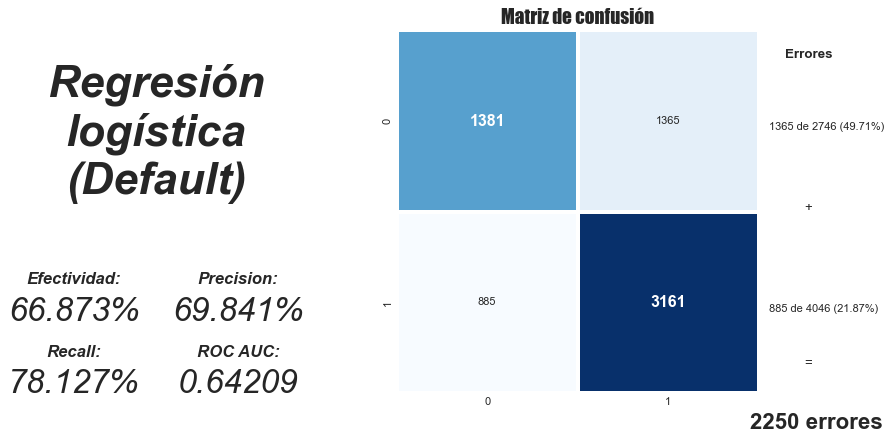

In [18]:
acc_LogModel, prec_LogModel, rec_LogModel, roc_LogModel = SupervisedUtils.model_cf('Regresión\nlogística\n(Default)',y_test,y_LogModel)

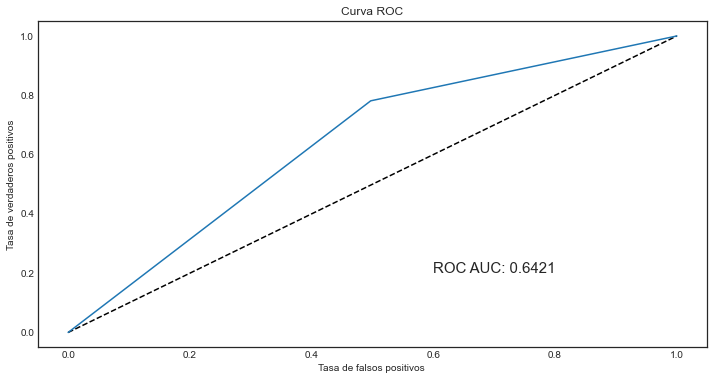

In [19]:
SupervisedUtils.grafica_curva_roc(y_test,y_LogModel)

#### Tunning de parámetro C

In [20]:
clist = np.logspace(-2,4,20,base=2)

LogitTemp=SupervisedUtils.LogisticRegression(random_state=12345, n_jobs=-1)

train_scores, test_scores = SupervisedUtils.validation_curve(
    LogitTemp,
    X_train,
    y_train,
    param_name='C',
    param_range=clist,
    cv=3,
    n_jobs=-1,
    scoring="accuracy")
    

In [21]:
cscores=list(map(np.mean,test_scores))
ctunning = pd.DataFrame(cscores,index=clist,columns=['Score en test'])
# ctunning

In [22]:
cbest=clist[np.argmax(cscores)]

Text(0.5, 1.0, 'Efectividad media de una regresión logística con parámetro C')

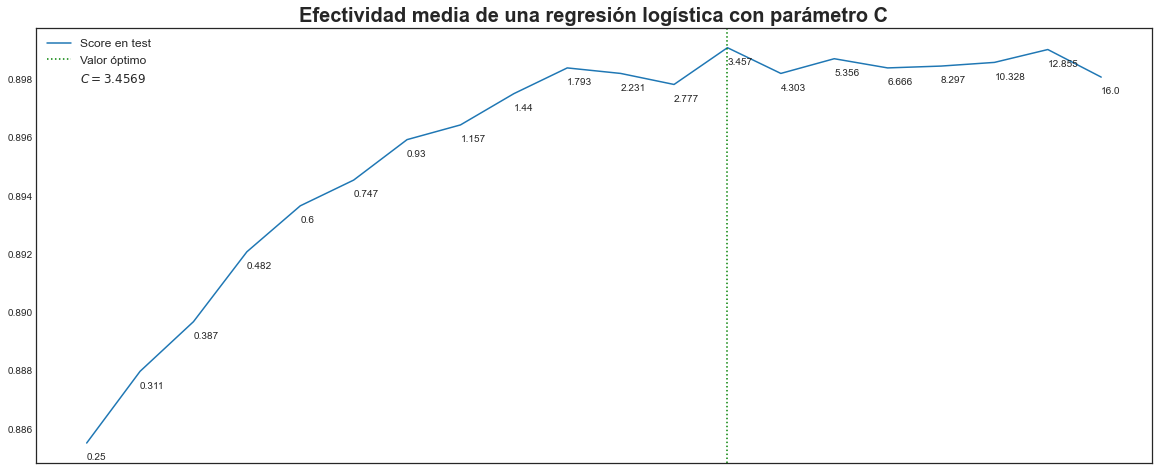

In [23]:
ctunning.plot(logx=True,figsize=(20,8))
plt.axvline(x=cbest,label='Valor óptimo',linestyle=':',color='green')
plt.plot([], [],' ',label=f'$C={round(cbest,4)}$')

plt.legend(fontsize = 'large')

for ind,i in enumerate(clist):
    plt.text(i,cscores[ind]-0.15*np.std(cscores),round(i,3))
    
plt.xticks([])
plt.title('Efectividad media de una regresión logística con parámetro C',size=20,fontweight='bold')

#### Mejor regresión logística

In [25]:
BestLogModel = SupervisedUtils.LogisticRegression(C=cbest,random_state=12345, n_jobs=-1)
BestLogModel

LogisticRegression(C=3.456887573126422, n_jobs=-1, random_state=12345)

In [26]:

BestLogModel.fit(X_train,y_train)
y_BestLogModel=BestLogModel.predict(X_test)
BestLogModel_train_score = BestLogModel.score(X_train,y_train)
print(f'Score en train: {BestLogModel_train_score}')
BestLogModel_test_score = BestLogModel.score(X_test,y_test)
print(f'Score en test: {BestLogModel_test_score}')

Score en train: 0.9011675607447144
Score en test: 0.6656360424028268


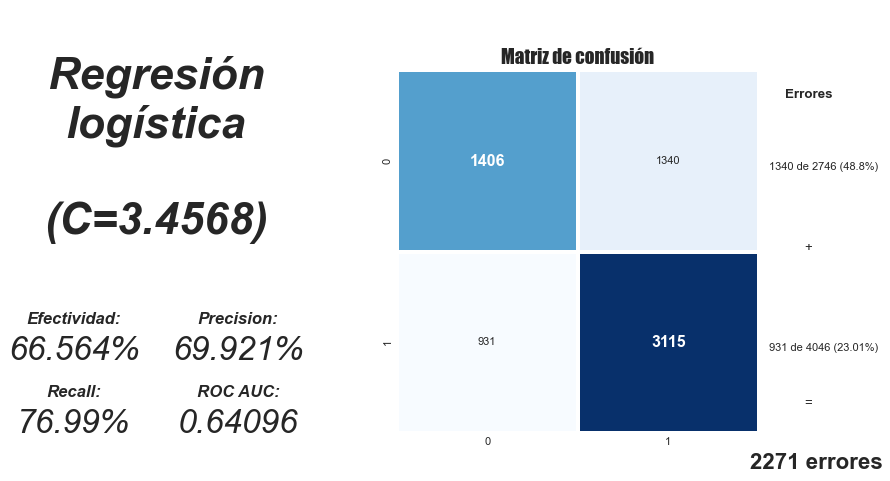

In [27]:
acc_BestLogModel, prec_BestLogModel, rec_BestLogModel, roc_BestLogModel = SupervisedUtils.model_cf('\nRegresión\nlogística\n\n(C=3.4568)',y_test,y_BestLogModel)

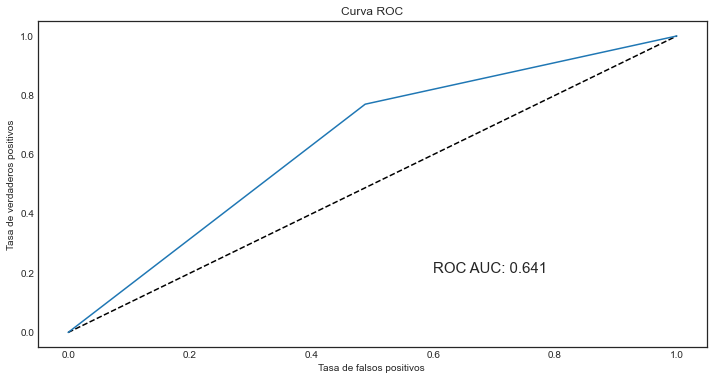

In [28]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestLogModel)

### Random Forest

#### Modelo default

In [29]:
RFModel = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)
RFModel

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [30]:

RFModel.fit(X_train,y_train)
y_RFModel=RFModel.predict(X_test)
RFModel_train_score = RFModel.score(X_train,y_train)
print(f'Score en train: {RFModel_train_score}')
RFModel_test_score = RFModel.score(X_test,y_test)
print(f'Score en test: {RFModel_test_score}')

Score en train: 1.0
Score en test: 0.684776207302709


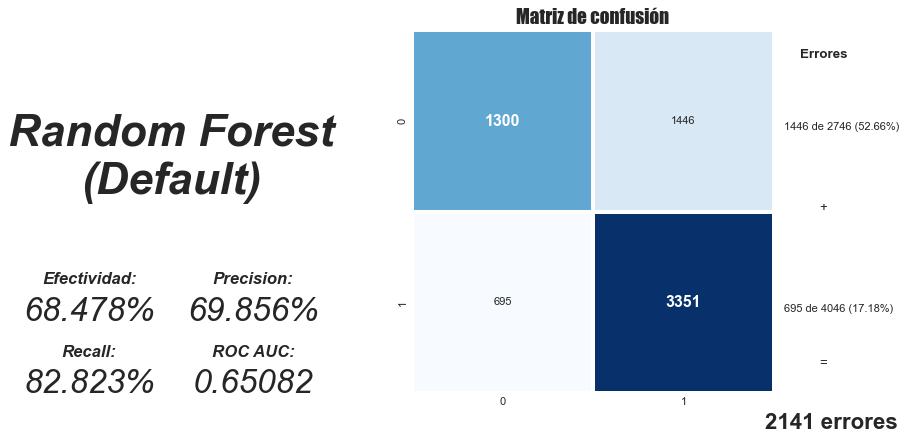

In [31]:
acc_RFModel, prec_RFmodel, rec_RFModel, roc_RFModel = SupervisedUtils.model_cf('Random Forest\n(Default)',y_test,y_RFModel)

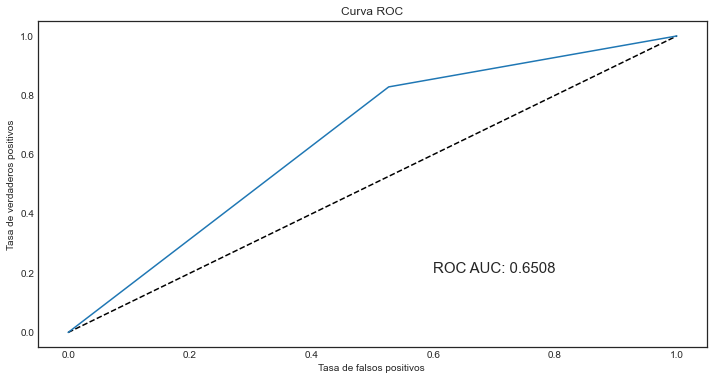

In [32]:
SupervisedUtils.grafica_curva_roc(y_test,y_RFModel)

#### Tunning de parámetros

In [33]:
param_grid={'n_estimators' : [10,50,100,200],
            'criterion' : ['gini','entropy'],
            'max_depth' : [None, 2,5,10,20,50],
            'min_samples_split' : [2,4,6,10],
            'min_samples_leaf' : [1,2,3],
           }

In [34]:
RF = SupervisedUtils.RandomForestClassifier(random_state=12345, n_jobs=-1)

In [35]:
search_RF = SupervisedUtils.HalvingGridSearchCV(RF, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 30
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 576
n_resources: 30
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 1/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=1.000, test=0.600) total time=   0.0s
[CV 2/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 2/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=0.947, test=0.800) total time=   0.0s
[CV 3/3; 1/576] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10
[CV 3/3; 1/576] END criterion=gini, max_depth=None, min_samples_leaf=1, min_

In [36]:
rftunning=pd.DataFrame(search_RF.cv_results_)

In [37]:
indrfmax=np.argmax(rftunning['mean_test_score'])
rfbest=rftunning.iloc[indrfmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

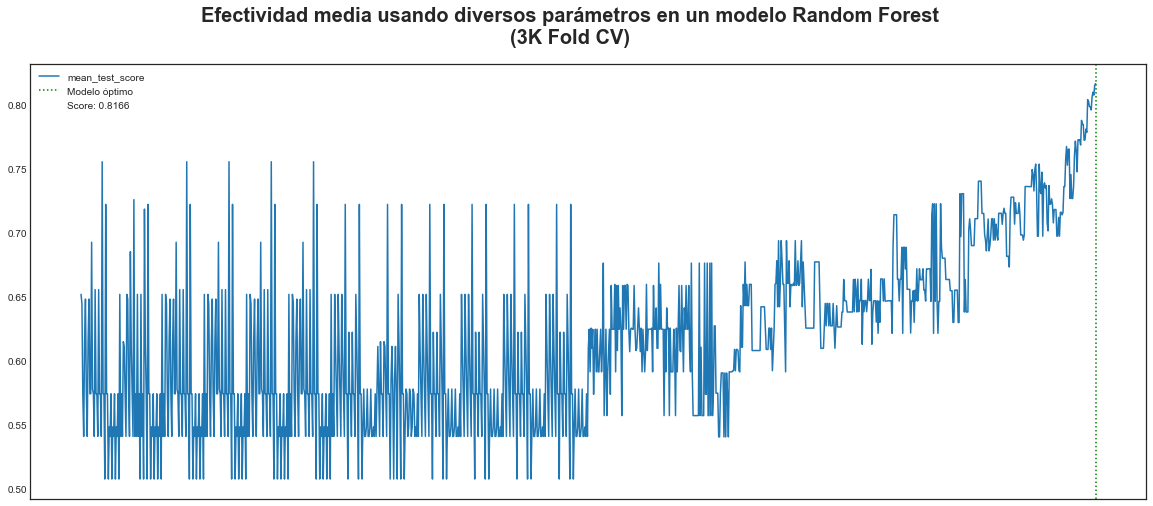

In [38]:
plt.figure(figsize=(8, 6), dpi=80)
    

rftunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indrfmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [39]:
rfbest

iter                                                                       9
n_resources                                                            15360
mean_fit_time                                                       1.422377
std_fit_time                                                        0.036833
mean_score_time                                                     0.044711
std_score_time                                                      0.007878
param_criterion                                                         gini
param_max_depth                                                           50
param_min_samples_leaf                                                     1
param_min_samples_split                                                   10
param_n_estimators                                                       100
params                     {'criterion': 'gini', 'max_depth': 50, 'min_sa...
split0_test_score                                                   0.814648

In [40]:
rftunning[[x for x in rftunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_criterion param_max_depth param_min_samples_leaf  \
1133            gini              20                      1   
1134         entropy              10                      2   
1135            gini              10                      1   
1136            gini              20                      1   
1137            gini              20                      2   
1138            gini              50                      2   
1139            gini              10                      2   
1140            gini              10                      1   
1141            gini              50                      1   
1142            gini              20                      1   
1143            gini              20                      1   
1144            gini              50                      1   
1145            gini              20                      2   
1146            gini              50                      2   
1147            gini              20                      1   
1148            gini              20                      2   
1149            gini              50                      1   
1150            gini              20                      1   
1151            gini              20                      1   
1152            gini              50                      1   

     param_min_samples_split param_n_estimators  mean_train_score  \
1133                      10                100          0.992179   
1134                       6                 10          0.964566   
1135                       2                100          0.990881   
1136                       2                100          1.000000   
1137                      10                100          0.984367   
1138                      10                100          0.984367   
1139                      10                100          0.972643   
1140                      10                100          0.978374   
1141                      10                100          0.991401   
1142                      10                100          0.990880   
1143                      10                100          0.993488   
1144                      10                100          0.993358   
1145                      10                100          0.988148   
1146                      10                100          0.987627   
1147                       2                100          1.000000   
1148                      10                100          0.984764   
1149                      10                100          0.993358   
1150                      10                100          0.992056   
1151                      10                100          0.990982   
1152                      10                100          0.993847   

      mean_test_score  
1133         0.772691  
1134         0.772787  
1135         0.768622  
1136         0.787900  
1137         0.784778  
1138         0.784778  
1139         0.772269  
1140         0.772790  
1141         0.781132  
1142         0.778525  
1143         0.804117  
1144         0.802815  
1145         0.798647  
1146         0.798386  
1147         0.796041  
1148         0.806356  
1149         0.809872  
1150         0.807658  
1151         0.815353  
1152         0.816590

#### Mejor modelo Random Forest

In [41]:
BestRFModel = SupervisedUtils.RandomForestClassifier(**rfbest['params'],random_state=12345, n_jobs=-1)
BestRFModel

RandomForestClassifier(max_depth=50, min_samples_split=10, n_jobs=-1,
                       random_state=12345)

In [42]:
BestRFModel.fit(X_train,y_train)
y_BestRFModel=BestRFModel.predict(X_test)
BestRFModel_train_score = BestRFModel.score(X_train,y_train)
print(f'Score en train: {BestRFModel_train_score}')
BestRFModel_test_score = BestRFModel.score(X_test,y_test)
print(f'Score en test: {BestRFModel_test_score}')

Score en train: 0.9942568633638371
Score en test: 0.6838928150765606


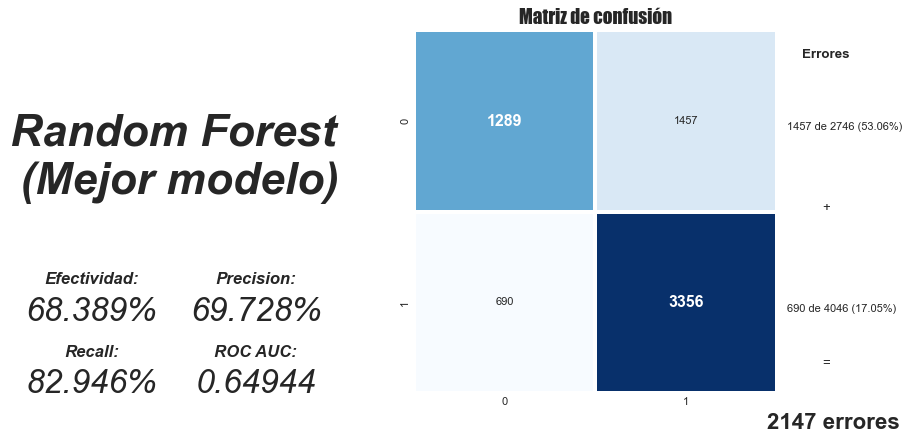

In [43]:
acc_BestRFModel, prec_BestRFModel, rec_BestRFModel, roc_BestRFModel = SupervisedUtils.model_cf('\nRandom Forest\n (Mejor modelo)',y_test,y_BestRFModel)

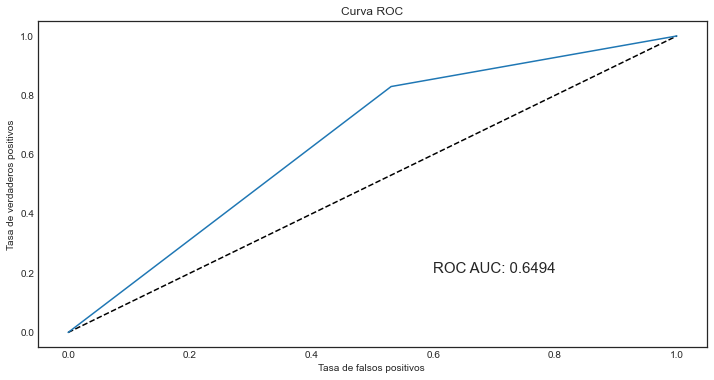

In [44]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestRFModel)

### KNN

#### Modelo default

In [45]:
KNNModel = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)
KNNModel

KNeighborsClassifier(n_jobs=-1)

In [46]:
KNNModel.fit(X_train,y_train)
y_KNNModel=KNNModel.predict(X_test)
KNNModel_train_score = KNNModel.score(X_train,y_train)
print(f'Score en train: {KNNModel_train_score}')
KNNModel_test_score = KNNModel.score(X_test,y_test)
print(f'Score en test: {KNNModel_test_score}')

Score en train: 0.8490375512780057
Score en test: 0.6671083627797408


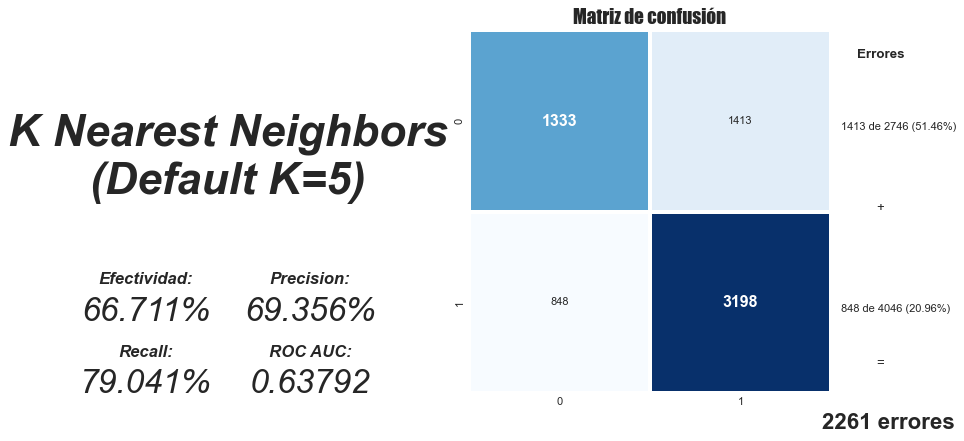

In [47]:
acc_KNNModel, prec_KNNModel, rec_KNNModel, roc_KNNModel = SupervisedUtils.model_cf('K Nearest Neighbors\n(Default K=5)',y_test,y_KNNModel)

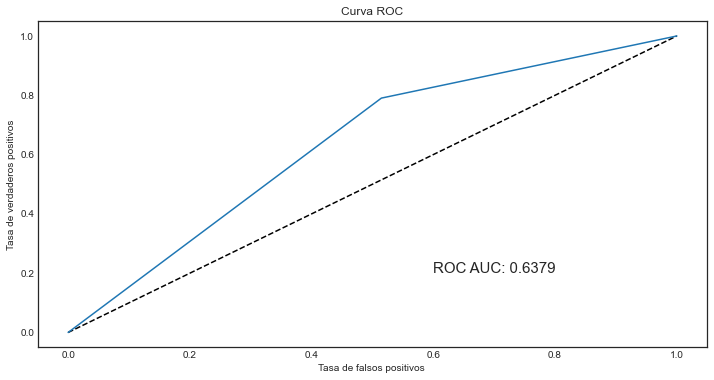

In [48]:
SupervisedUtils.grafica_curva_roc(y_test,y_KNNModel)

#### Tunning de parámetros

In [49]:
param_grid={'n_neighbors':[2,5,7,10,50],
            'weights' : ['uniform', 'distance'],
            'leaf_size':[10,30,50,100],
            'p':[1,2]
           }

In [50]:
KNN = SupervisedUtils.KNeighborsClassifier(n_jobs=-1)

In [51]:
search_KNN = SupervisedUtils.HalvingGridSearchCV(KNN, cv=3, param_grid=param_grid,factor = 2,random_state=12345,verbose=np.inf,scoring="accuracy").fit(X_train, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 247
max_resources_: 15845
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 247
Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 1/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.799, test=0.610) total time=   0.0s
[CV 2/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 2/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.762, test=0.573) total time=   0.0s
[CV 3/3; 1/80] START leaf_size=10, n_neighbors=2, p=1, weights=uniform..........
[CV 3/3; 1/80] END leaf_size=10, n_neighbors=2, p=1, weights=uniform;, score=(train=0.811, test=0.561) total time=   0.0s
[CV 1/3; 2/80] START leaf_size=10, n_neighbors=2, p=1, weights=distance.........
[CV 1/3; 2/80] END leaf_size=10, n_neighbors=2,

In [52]:
knntunning=pd.DataFrame(search_KNN.cv_results_)

In [53]:
indknnmax=np.argmax(knntunning['mean_test_score'])
knnbest=knntunning.iloc[indknnmax,:]

Text(0.5, 0.98, 'Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)')

<Figure size 640x480 with 0 Axes>

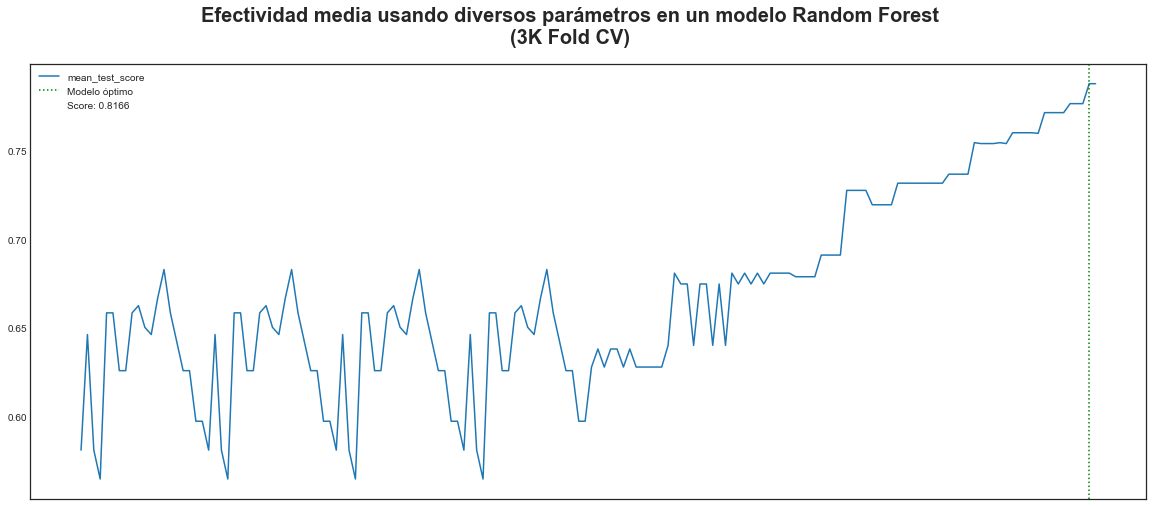

In [54]:
plt.figure(figsize=(8, 6), dpi=80)
    

knntunning.plot(use_index=True, y='mean_test_score',figsize=(20,8))

# for ind,i in enumerate(rftunning.index):
#     plt.text(ind,rftunning['mean_test_score'][ind],str(ind),ha='center')

plt.gca().set_xticks([])
plt.axvline(x=indknnmax,label='Modelo óptimo',linestyle=':',color='green')
plt.plot([],[],' ',label=f"Score: {round(rftunning['mean_test_score'][indrfmax],4)}")
plt.legend()

plt.suptitle('Efectividad media usando diversos parámetros en un modelo Random Forest\n(3K Fold CV)',size=20,fontweight='bold')

In [55]:
knnbest

iter                                                                  6
n_resources                                                       15808
mean_fit_time                                                  0.025599
std_fit_time                                                   0.000941
mean_score_time                                                3.066606
std_score_time                                                 0.075527
param_leaf_size                                                      50
param_n_neighbors                                                    10
param_p                                                               1
param_weights                                                  distance
params                {'leaf_size': 50, 'n_neighbors': 10, 'p': 1, '...
split0_test_score                                              0.791232
split1_test_score                                              0.780224
split2_test_score                                              0

In [56]:
knntunning[[x for x in knntunning if 'param_' in x] + ['mean_train_score','mean_test_score']].tail(20)

param_leaf_size param_n_neighbors param_p param_weights  mean_train_score  \
140              10                 7       1      distance           1.00000   
141             100                 7       1       uniform           0.81144   
142              10                 7       1       uniform           0.81144   
143              30                 7       1       uniform           0.81144   
144              30                 7       1      distance           1.00000   
145              50                 7       1       uniform           0.81144   
146              10                10       1      distance           1.00000   
147             100                10       1      distance           1.00000   
148              50                10       1      distance           1.00000   
149              30                10       1      distance           1.00000   
150              30                 7       1      distance           1.00000   
151              10                10       1      distance           1.00000   
152             100                10       1      distance           1.00000   
153              50                10       1      distance           1.00000   
154              30                10       1      distance           1.00000   
155             100                10       1      distance           1.00000   
156              50                10       1      distance           1.00000   
157              30                10       1      distance           1.00000   
158              50                10       1      distance           1.00000   
159              30                10       1      distance           1.00000   

     mean_test_score  
140         0.754306  
141         0.753799  
142         0.753799  
143         0.753799  
144         0.754306  
145         0.753799  
146         0.759878  
147         0.759878  
148         0.759878  
149         0.759878  
150         0.759555  
151         0.771197  
152         0.771197  
153         0.771197  
154         0.771197  
155         0.776259  
156         0.776259  
157         0.776259  
158         0.787486  
159         0.787486

#### Mejor modelo KNN

In [57]:
BestKNNModel = SupervisedUtils.KNeighborsClassifier(**knnbest['params'],n_jobs=-1)
BestKNNModel

KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=10, p=1,
                     weights='distance')

In [58]:
BestKNNModel.fit(X_train,y_train)
y_BestKNNModel=BestKNNModel.predict(X_test)
BestKNNModel_train_score = BestKNNModel.score(X_train,y_train)
print(f'Score en train: {BestKNNModel_train_score}')
BestKNNModel_test_score = BestKNNModel.score(X_test,y_test)
print(f'Score en test: {BestKNNModel_test_score}')

Score en train: 1.0
Score en test: 0.6834511189634864


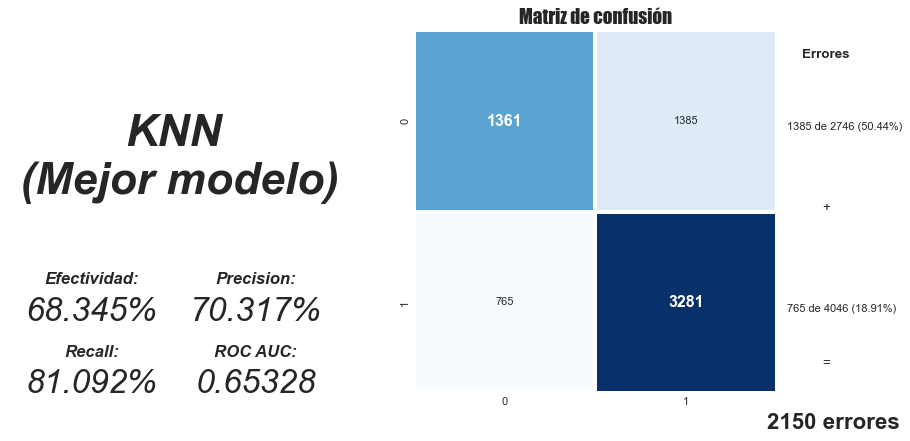

In [59]:
acc_BestKNNModel, prec_BestKNNModel, rec_BestKNNModel, roc_BestKNNModel = SupervisedUtils.model_cf('\nKNN\n (Mejor modelo)',y_test,y_BestKNNModel)

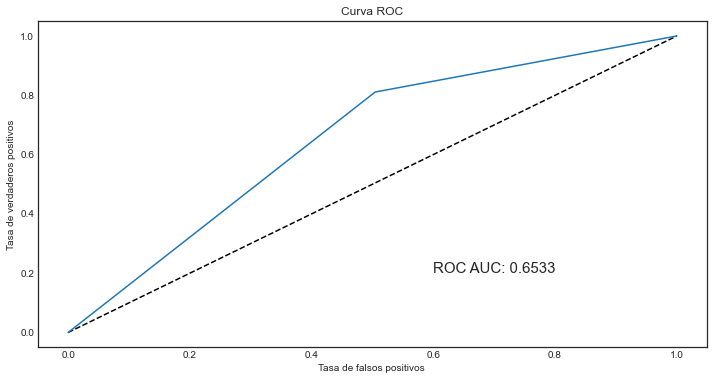

In [60]:
SupervisedUtils.grafica_curva_roc(y_test,y_BestKNNModel)

### Ensambles

#### Ensamble de modelos default

In [61]:
y_preds_def= pd.DataFrame(LogModel.predict(X_train), columns=['Regresión logística'])
y_preds_def['Random Forest']=RFModel.predict(X_train)
y_preds_def['KNN']=KNNModel.predict(X_train)
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    0                        1
6                    0              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

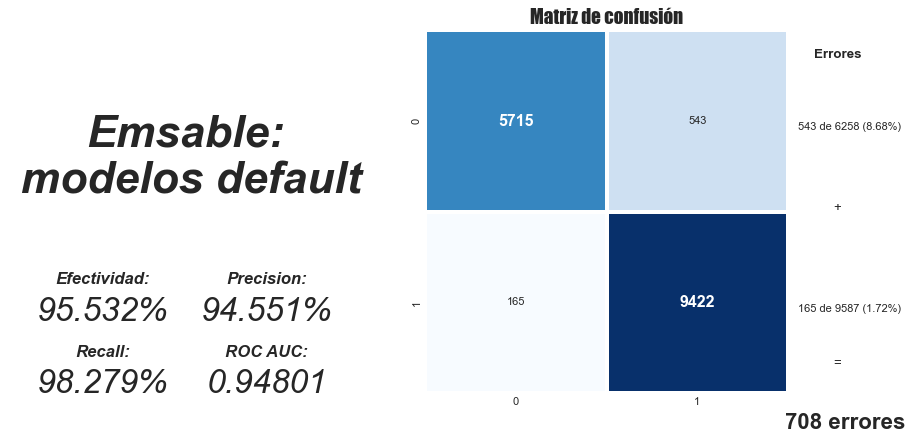

In [62]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_train,y_ensdefault)

In [63]:
y_preds_def= pd.DataFrame(y_LogModel, columns=['Regresión logística'])
y_preds_def['Random Forest']=y_RFModel
y_preds_def['KNN']=y_KNNModel
y_preds_def['Emsable modelos default']=y_preds_def.mode(axis=1)
y_ensdefault=y_preds_def['Emsable modelos default']
y_preds_def.head(10)

Regresión logística  Random Forest  KNN  Emsable modelos default
0                    1              1    1                        1
1                    1              0    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    0                        1
5                    0              0    1                        0
6                    1              0    1                        1
7                    0              0    0                        0
8                    0              1    1                        1
9                    1              1    1                        1

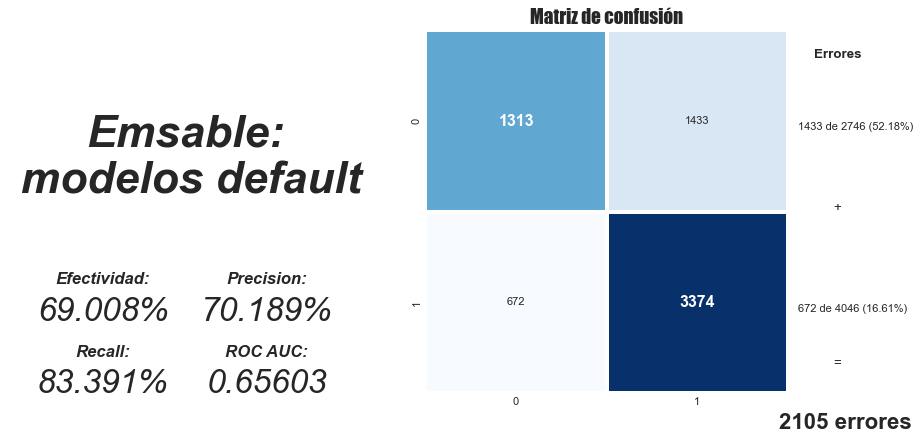

In [64]:
acc_ensdefault, prec_ensdefault, rec_ensdefault, roc_ensdefault = SupervisedUtils.model_cf('Emsable:\n modelos default',y_test,y_ensdefault)

#### Ensamble de modelos seleccionados

In [65]:
y_preds_best= pd.DataFrame(BestLogModel.predict(X_train), columns=['Regresión logística'])
y_preds_best['Random Forest']=BestRFModel.predict(X_train)
y_preds_best['KNN']=BestKNNModel.predict(X_train)
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    1              1    1                        1
6                    0              0    0                        0
7                    1              1    1                        1
8                    1              1    1                        1
9                    1              1    1                        1

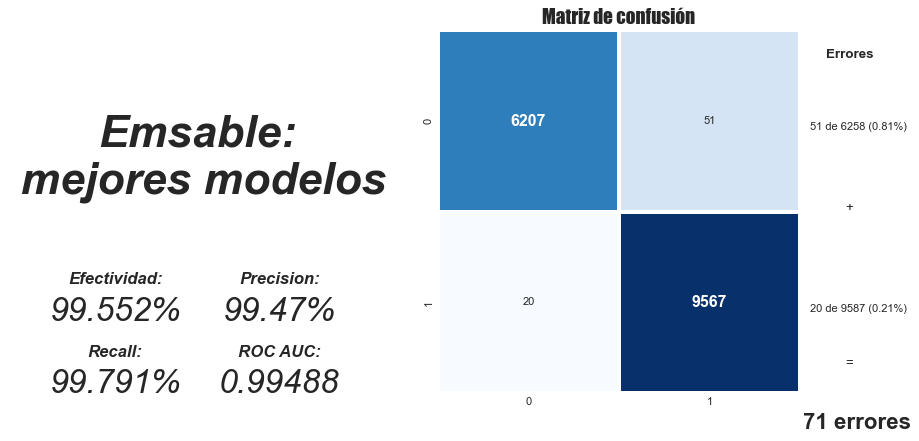

In [66]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_train,y_ensbest)

In [67]:
y_preds_best= pd.DataFrame(y_BestLogModel, columns=['Regresión logística'])
y_preds_best['Random Forest']=y_BestRFModel
y_preds_best['KNN']=y_BestKNNModel
y_preds_best['Emsable mejores modelos']=y_preds_best.mode(axis=1)
y_ensbest=y_preds_best['Emsable mejores modelos']
y_preds_best.head(10)

Regresión logística  Random Forest  KNN  Emsable mejores modelos
0                    1              1    1                        1
1                    1              1    1                        1
2                    1              1    1                        1
3                    1              1    1                        1
4                    1              1    1                        1
5                    0              1    1                        1
6                    1              1    1                        1
7                    0              0    0                        0
8                    0              1    1                        1
9                    1              1    1                        1

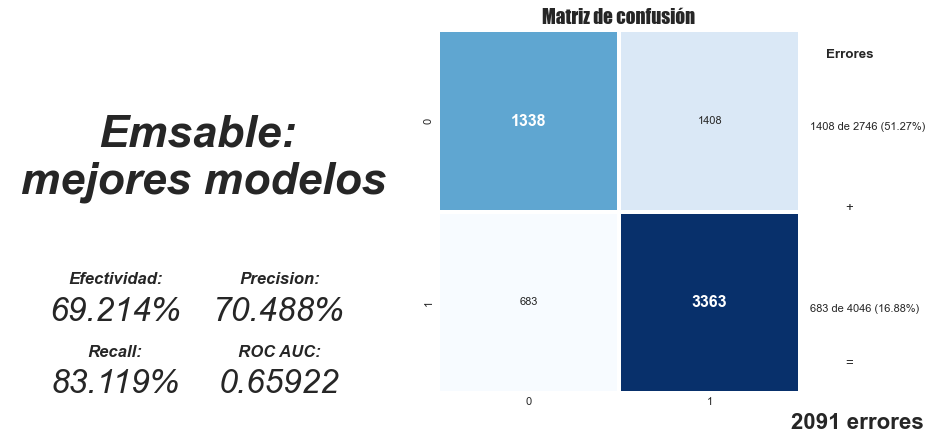

In [68]:
acc_ensbest, prec_ensbest, rec_ensbest, roc_ensbest = SupervisedUtils.model_cf('Emsable:\n mejores modelos',y_test,y_ensbest)

### Comparación de modelos

#### Métricas de modelos default

In [69]:
ModelMetricsDef= pd.DataFrame([acc_LogModel,prec_LogModel,rec_LogModel,roc_LogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetricsDef['Random Forest']=[acc_RFModel,prec_RFmodel,rec_RFModel,roc_RFModel]
ModelMetricsDef['KNN']=[acc_KNNModel,prec_KNNModel,rec_KNNModel,roc_KNNModel]
ModelMetricsDef['Ensamble: Default']=[acc_ensdefault,prec_ensdefault,rec_ensdefault,roc_ensdefault]

In [70]:
ModelMetricsDef

Regresión logística  Random Forest       KNN  \
Efectividad                 0.668730       0.684780  0.667110   
Precision                   0.698410       0.698560  0.693560   
Recall                      0.781270       0.828230  0.790410   
ROC AUC - Score             0.642089       0.650821  0.637922   

                 Ensamble: Default  
Efectividad                0.69008  
Precision                  0.70189  
Recall                     0.83391  
ROC AUC - Score            0.65603

In [71]:
ModelMetricsDef_d2v=ModelMetricsDef
ModelMetricsDef_d2v.to_excel('ModelMetricsDef_d2v.xlsx')

#### Métricas de modelos seleccionados

In [74]:
ModelMetrics= pd.DataFrame([acc_BestLogModel,prec_BestLogModel,rec_BestLogModel,roc_BestLogModel],index=['Efectividad','Precision','Recall','ROC AUC - Score'],columns=['Regresión logística'])
ModelMetrics['Random Forest']=[acc_BestRFModel,prec_BestRFModel,rec_BestRFModel,roc_BestRFModel]
ModelMetrics['KNN']=[acc_BestKNNModel,prec_BestKNNModel,rec_BestKNNModel,roc_BestKNNModel]
ModelMetrics['Ensamble: Mejores modelos']=[acc_ensbest,prec_ensbest,rec_ensbest,roc_ensbest]

In [75]:
ModelMetrics

Regresión logística  Random Forest       KNN  \
Efectividad                 0.665640       0.683890  0.683450   
Precision                   0.699210       0.697280  0.703170   
Recall                      0.769900       0.829460  0.810920   
ROC AUC - Score             0.640957       0.649436  0.653277   

                 Ensamble: Mejores modelos  
Efectividad                       0.692140  
Precision                         0.704880  
Recall                            0.831190  
ROC AUC - Score                   0.659223

In [76]:
ModelMetrics_d2v=ModelMetrics
ModelMetrics_d2v.to_excel('ModelMetrics_d2v.xlsx')

### Resumen

Text(0.5, 0.98, 'Métricas de modelos entrenados')

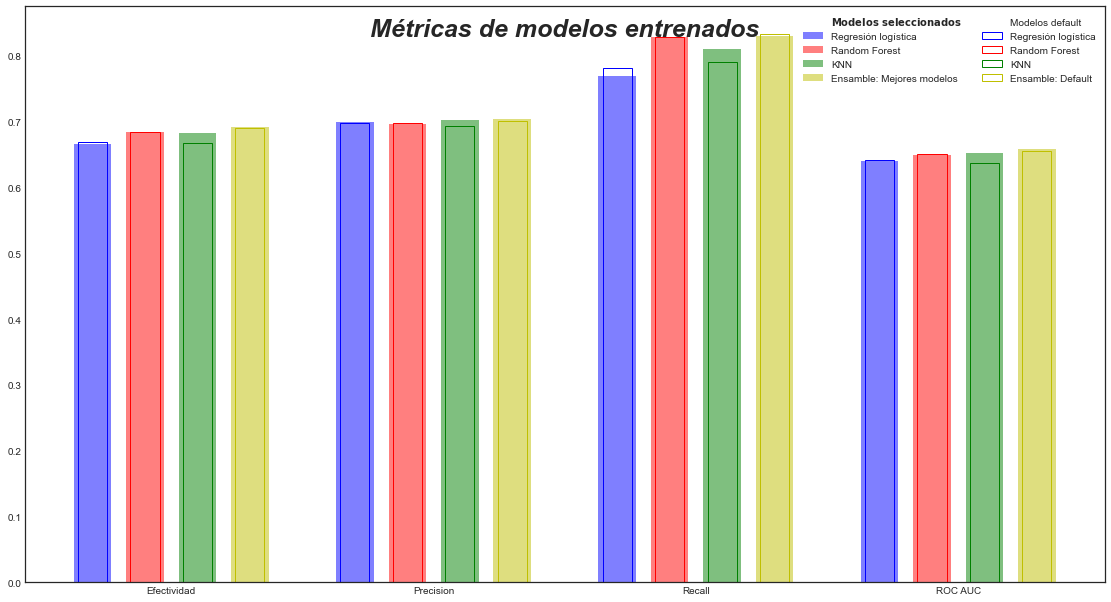

In [77]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="$\\bf{Modelos\ seleccionados}$")

for ind,i in enumerate(ModelMetrics.columns):
    ax.bar(xticks + ind/5, ModelMetrics[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos default')

for ind,i in enumerate(ModelMetricsDef.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('Métricas de modelos entrenados', size=25,fontstyle='italic',fontweight='bold')

In [78]:
iterables=[['Modelos seleccionados','Modelos default'],ModelMetrics.columns]

In [79]:
Metrics = pd.concat([ModelMetrics,ModelMetricsDef],axis=1)

In [80]:
Metrics.columns=pd.MultiIndex.from_product(iterables, names=["", ""])

In [81]:
Metrics

Modelos seleccionados                          \
                  Regresión logística Random Forest       KNN   
Efectividad                  0.665640      0.683890  0.683450   
Precision                    0.699210      0.697280  0.703170   
Recall                       0.769900      0.829460  0.810920   
ROC AUC - Score              0.640957      0.649436  0.653277   

                                              Modelos default                \
                Ensamble: Mejores modelos Regresión logística Random Forest   
Efectividad                      0.692140            0.668730      0.684780   
Precision                        0.704880            0.698410      0.698560   
Recall                           0.831190            0.781270      0.828230   
ROC AUC - Score                  0.659223            0.642089      0.650821   

                                                     
                      KNN Ensamble: Mejores modelos  
Efectividad      0.667110                   0.69008  
Precision        0.693560                   0.70189  
Recall           0.790410                   0.83391  
ROC AUC - Score  0.637922                   0.65603

## TF-IDF vs Doc2Vec

In [87]:
ModelMetricsDef_TFID = pd.read_excel('ModelMetricsDef_TFID.xlsx',index_col=0)
ModelMetricsDef_d2v = pd.read_excel('ModelMetricsDef_d2v.xlsx',index_col=0)
ModelMetrics_TFID = pd.read_excel('ModelMetrics_TFID.xlsx',index_col=0)
ModelMetrics_d2v = pd.read_excel('ModelMetrics_d2v.xlsx',index_col=0)

Text(0.5, 1.115, 'TF-IDF vs Doc2Vec\n (Modelos default)')

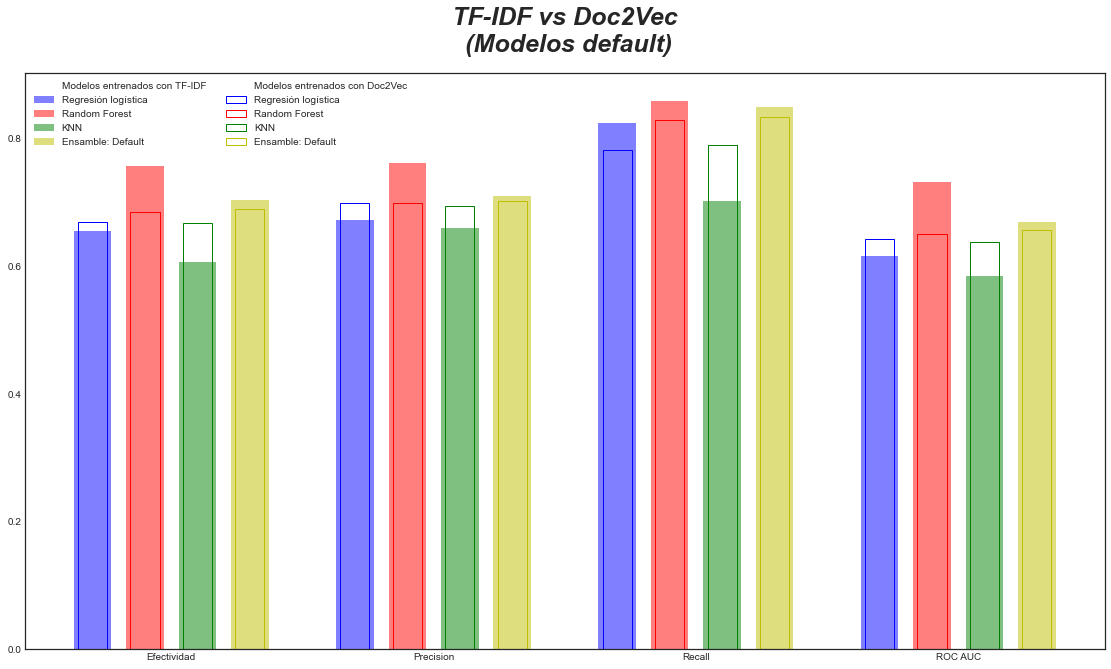

In [89]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetricsDef_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetricsDef_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetricsDef_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Modelos default)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

Text(0.5, 1.115, 'TF-IDF vs Doc2Vec\n (Mejores modelos)')

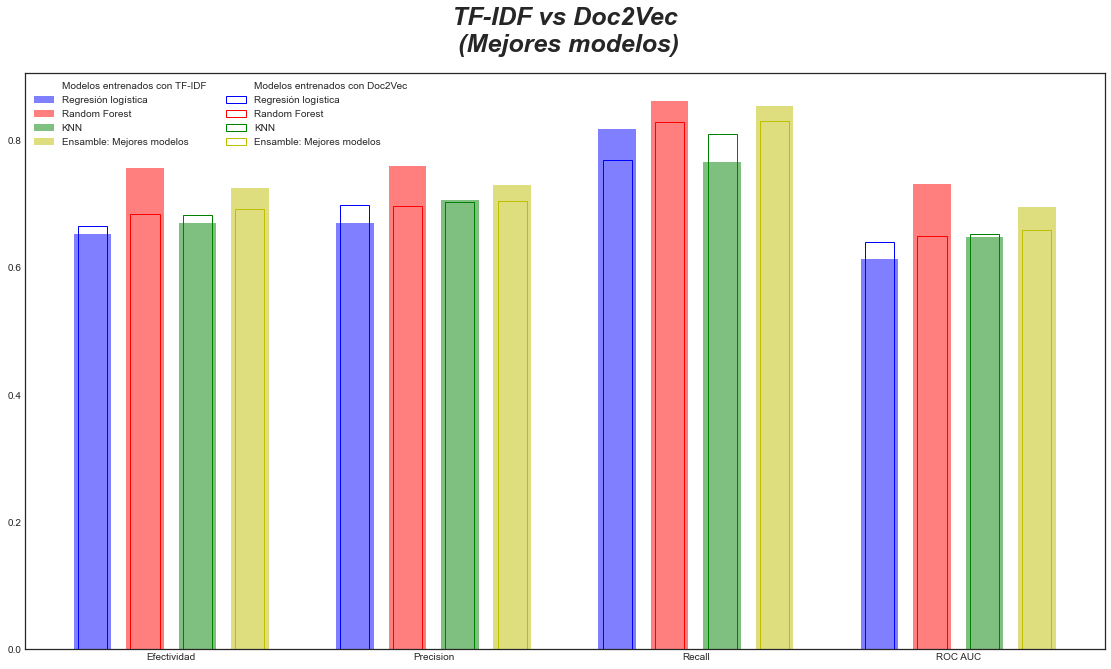

In [90]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

xticks = np.arange(4)

colors = ['b','r','g','y']

ax.plot([],[],' ',label="Modelos entrenados con TF-IDF")

for ind,i in enumerate(ModelMetrics_TFID.columns):
    ax.bar(xticks + ind/5, ModelMetrics_TFID[i], color = colors[ind], width = 1/7,alpha=0.5,label=i)
    
plt.plot([],[],' ',label='Modelos entrenados con Doc2Vec')

for ind,i in enumerate(ModelMetrics_d2v.columns):
    ax.bar(xticks + ind/5, ModelMetrics_d2v[i],edgecolor =colors[ind], width = 1/9,label=i,fill=False)
    
    
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,4,5,1,6,7,8,9]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],ncol=2) 

ax.set_xticks(xticks+0.3, ('Efectividad', 'Precision', 'Recall', 'ROC AUC'))

fig.suptitle('TF-IDF vs Doc2Vec\n (Mejores modelos)', y=1.115,size=25,fontstyle='italic',fontweight='bold')

# Elección de modelo y bootstrap

In [4]:
BestLogModel = SupervisedUtils.LogisticRegression(C=3.456887573126422,random_state=12345, n_jobs=-1)
BestRFModel = SupervisedUtils.RandomForestClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=4,n_estimators=200,random_state=12345, n_jobs=-1)
BestKNNModel = SupervisedUtils.KNeighborsClassifier(leaf_size=50, n_jobs=-1, n_neighbors=50, weights='distance')

In [5]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

In [6]:
engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']

In [7]:
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

In [8]:
from sklearn.preprocessing import MinMaxScaler

## Boostrap

### TF-IDF

In [9]:
num_records = X.shape[0]
bootstrap_errors_logit = []
bootstrap_errors_rf = []
bootstrap_errors_knn = []
bootstrap_errors_ens = []

np.random.seed(0)

for _ in tqdm(range(250)):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)

    X_train_b, y_train_b = X.iloc[train_indices,:], y[train_indices]
    X_test_b, y_test_b = X.iloc[test_indices,:], y[test_indices]


    counts = X_train_b['genres'].str.split('-').explode().value_counts(True)
    mask = counts>0.05
    genres_mask = counts[mask].index
    genresaux = X_train_b['genres'].str.split('-')
    genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
    genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
    genre_vc.fit(genresaux)
    genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train_b.index)
    genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
    X_train_b = pd.concat([X_train_b,genresaux],axis=1).drop(columns = ['genres'])

    genresaux = X_test_b['genres'].str.split('-')
    genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
    genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test_b.index)
    genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
    X_test_b = pd.concat([X_test_b,genresaux],axis=1).drop(columns = ['genres'])

    counts = X_train_b['original_language'].value_counts(True)
    mask = counts>0.10
    language_mask = counts[mask].index
    X_train_b.loc[~X_train_b['original_language'].isin(language_mask),'original_language'] = 'OTROS'
    X_train_b = pd.get_dummies(X_train_b,columns = ['original_language'])

    X_test_b.loc[~X_test_b['original_language'].isin(language_mask),'original_language'] = 'OTROS'
    X_test_b = pd.get_dummies(X_test_b,columns = ['original_language'])


    overview_vc = StringUtils.TfidfVectorizer(max_features=100)
    overview_vc.fit(X_train_b['overview_clean'])
    X_overview_train = overview_vc.transform(X_train_b['overview_clean']).toarray()
    X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train_b.index)
    X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
    X_overview_test  = overview_vc.transform(X_test_b['overview_clean']).toarray()
    X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test_b.index)
    X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

    keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
    keywords_vc.fit(X_train_b['keywords'].astype(str))
    X_keywords_train = keywords_vc.transform(X_train_b['keywords'].astype(str)).toarray()
    X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train_b.index)
    X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
    X_keywords_test  = keywords_vc.transform(X_test_b['keywords'].astype(str)).toarray()
    X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test_b.index)
    X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

    X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
    X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

    X_train_b = pd.concat([X_train_b.drop(columns=stringvars),X_string_train],axis=1)
    X_test_b = pd.concat([X_test_b.drop(columns=stringvars),X_string_test],axis=1)
    

    sc = MinMaxScaler()
    sc.fit(X_train_b)
    X_train_b = sc.transform(X_train_b)
    X_test_b = sc.transform(X_test_b)
        

    # Logit model L2
    BestLogModel.fit(X_train_b, y_train_b)
    y_Log=BestLogModel.predict(X_test_b)
    bootstrap_errors_logit.append(SupervisedUtils.roc_auc_score(y_test_b, y_Log))
    
    # RF model
    BestRFModel.fit(X_train_b, y_train_b)
    y_RF=BestRFModel.predict(X_test_b)
    bootstrap_errors_rf.append(SupervisedUtils.roc_auc_score(y_test_b, y_RF))
    
    # KNN
    BestKNNModel.fit(X_train_b, y_train_b)
    y_KNN = BestKNNModel.predict(X_test_b)
    bootstrap_errors_knn.append(SupervisedUtils.roc_auc_score(y_test_b, y_KNN))
    
    # Ensamble
    y_preds_best= pd.DataFrame(y_Log, columns=['Regresión logística'])
    y_preds_best['Random Forest']=y_RF
    y_preds_best['KNN']=y_KNN
    y_preds_best['Ensable mejores modelos']=y_preds_best.mode(axis=1)
    y_ens = y_preds_best['Ensable mejores modelos']
    bootstrap_errors_ens.append(SupervisedUtils.roc_auc_score(y_test_b, y_ens))

100%|██████████| 250/250 [1:05:16<00:00, 15.67s/it]


## Estadísticas bootstrap

In [10]:
bootstrapdb=pd.DataFrame(np.array([bootstrap_errors_logit,bootstrap_errors_rf,bootstrap_errors_knn,bootstrap_errors_ens]).transpose(),columns=['Regresión logistica','Random Forest','KNN','Ensamble: Mejores modelos'])

In [11]:
bootstrapdb.to_excel('BootstrapMetrics.xlsx')

In [12]:
bootstrap_metrics=bootstrapdb.describe(percentiles=[0.025,0.975])
bootstrap_metrics

Regresión logistica  Random Forest         KNN  \
count           250.000000     250.000000  250.000000   
mean              0.615280       0.728830    0.656076   
std               0.004417       0.004760    0.006916   
min               0.602991       0.713111    0.636083   
2.5%              0.607624       0.718566    0.642199   
50%               0.615332       0.728897    0.656084   
97.5%             0.623524       0.737528    0.670103   
max               0.625320       0.741073    0.677144   

       Ensamble: Mejores modelos  
count                 250.000000  
mean                    0.699471  
std                     0.005589  
min                     0.685122  
2.5%                    0.689576  
50%                     0.699513  
97.5%                   0.710102  
max                     0.714155

Text(0.5, 1.0, 'Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)')

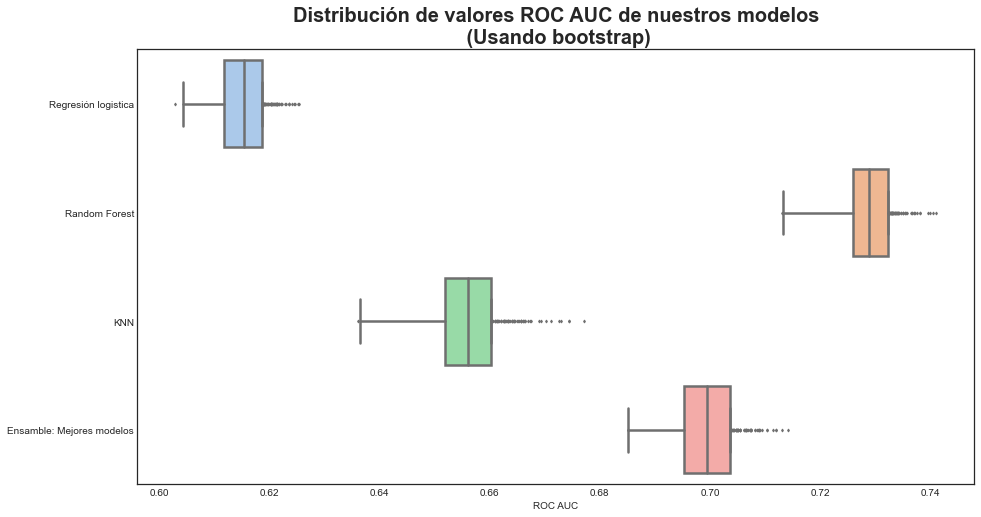

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(data=bootstrapdb,palette='pastel',whis=(0.025,0.975),orient = 'h',fliersize=2,linewidth=2.5)
plt.xlabel('ROC AUC')
plt.title('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

Text(0.5, 1.0, 'Valor medio de los valores ROC AUC de nuestros modelos\n(usando bootstrap)')

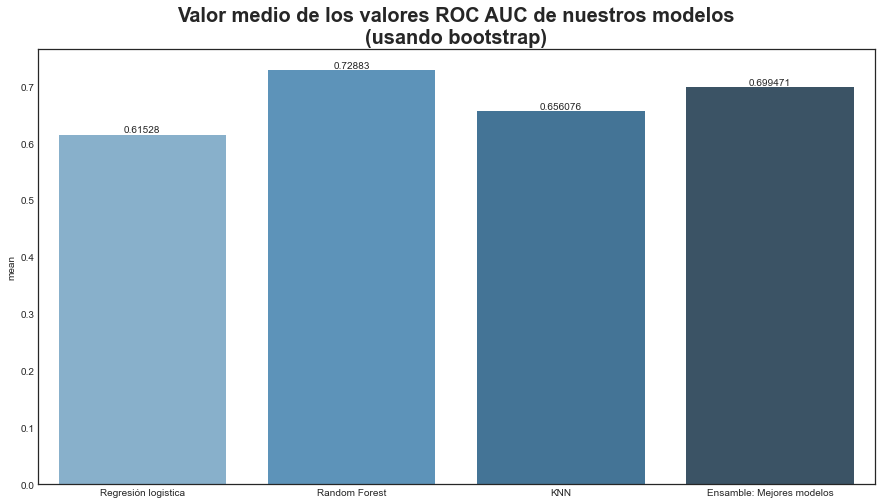

In [14]:
plt.figure(figsize=(15,8))
g = sns.barplot(x=bootstrap_metrics.T.index,y=bootstrap_metrics.T['mean'],palette="Blues_d")
g.bar_label(g.containers[0])
plt.title('Valor medio de los valores ROC AUC de nuestros modelos\n(usando bootstrap)',size=20,fontweight='bold')

Text(0.5, 0.98, 'Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)')

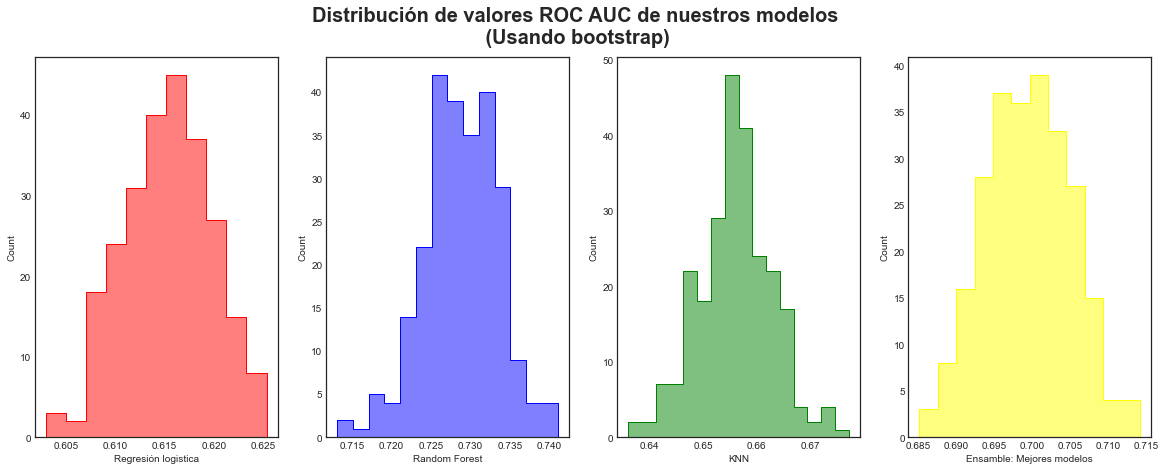

In [15]:
fig, ax = plt.subplots(1,4,figsize=(20,7))

sns.histplot(bootstrapdb,x='Regresión logistica',ax=ax[0],element="step",alpha=0.5,color='red')
sns.histplot(bootstrapdb,x='Random Forest',ax=ax[1],element="step",alpha=0.5,color='blue')
sns.histplot(bootstrapdb,x='KNN',ax=ax[2],element="step",alpha=0.5,color='green')
sns.histplot(bootstrapdb,x='Ensamble: Mejores modelos',ax=ax[3],element="step",alpha=0.5,color='yellow')

fig.suptitle('Distribución de valores ROC AUC de nuestros modelos\n (Usando bootstrap)',size=20,fontweight='bold')

## **Elección final**

> Finalmente, tras todos los modelos entrenados y con base en el bootstrap, podemos decir que **el mejor modelo para atacar nuestro problema es la regresión logística regularizada**, brinda mejores métricas y mas estables.  
>
> Además, se puede tener dos variantes, entrenada con TF-IDF o Doc2Vec pero como se ha expuesto y recalcado, el método Doc2Vec es mucho mas eficaz y mas rápido.

>> **Elección final: Regresión logística regularizada entrenada con word embedding Doc2Vec**

# Redes Neuronales

In [ ]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import BatchNormalization,Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Embedding, GRU, LSTM
from keras.layers import concatenate

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
tf.config.list_physical_devices('GPU') 

 ##  Método 1


In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_train = pd.concat([X_train,genresaux],axis=1).drop(columns = ['genres'])

genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genresaux = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
genresaux.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]
X_test = pd.concat([X_test,genresaux],axis=1).drop(columns = ['genres'])

counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train = pd.get_dummies(X_train,columns = ['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test = pd.get_dummies(X_test,columns = ['original_language'])


overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])
X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))
X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]

X_string_train = pd.concat([X_overview_train,X_keywords_train],axis=1)
X_string_test = pd.concat([X_overview_test,X_keywords_test],axis=1)

X_train = pd.concat([X_train.drop(columns=stringvars),X_string_train],axis=1)
X_test = pd.concat([X_test.drop(columns=stringvars),X_string_test],axis=1)
    
sc = MinMaxScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
x_input = Input(shape = (X_train.shape[1],))

x = Dropout(0.2) (x_input)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=x_input, outputs=pred)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True,dpi=300)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = X_train,
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=(X_test,y_test)
                )

In [ ]:
y_DL1 = model.predict(X_test)

In [ ]:
acc_DL1, prec_DL1, rec_DL1, roc_DL1 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 1)',y_test,y_DL1)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL1)

 ##  Método 2



In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
X_train_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
X_train_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
X_test_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
X_test_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train_language = pd.get_dummies(X_train['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test_language = pd.get_dummies(X_test['original_language'])


overview_vc = StringUtils.TfidfVectorizer(max_features=100)
overview_vc.fit(X_train['overview_clean'])
X_overview_train = overview_vc.transform(X_train['overview_clean']).toarray()
X_overview_train = pd.DataFrame(X_overview_train).set_index(X_train.index)
X_overview_train.columns  = ['overview_' + str(j) for j in range(X_overview_train.shape[1])]
X_overview_test  = overview_vc.transform(X_test['overview_clean']).toarray()
X_overview_test = pd.DataFrame(X_overview_test).set_index(X_test.index)
X_overview_test.columns  = ['overview_' + str(j) for j in range(X_overview_test.shape[1])]

keywords_vc = StringUtils.TfidfVectorizer(tokenizer= lambda x: x.split('-'),max_features=100)
keywords_vc.fit(X_train['keywords'].astype(str))
X_keywords_train = keywords_vc.transform(X_train['keywords'].astype(str)).toarray()
X_keywords_train = pd.DataFrame(X_keywords_train).set_index(X_train.index)
X_keywords_train.columns  = ['keywords_' + str(j) for j in range(X_keywords_train.shape[1])]
X_keywords_test  = keywords_vc.transform(X_test['keywords'].astype(str)).toarray()
X_keywords_test = pd.DataFrame(X_keywords_test).set_index(X_test.index)
X_keywords_test.columns  = ['keywords_' + str(j) for j in range(X_keywords_test.shape[1])]


X_train_feat = X_train['year','month','budget','runtime']
X_test_feat = X_test['year','month','budget','runtime']
    
# sc = MinMaxScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
x_genre_input = Input(shape = (X_train_genre.shape[1],))
x_language_input = Input(shape = (X_train_language.shape[1],))
x_overview_input = Input(shape = (X_overview_train.shape[1],))
x_keywords_input = Input(shape = (X_keywords_train.shape[1],))
x_feat_input = Input(shape= (X_train_feat.shape[0],))


x_cat = concatenate([x_genre_input,x_language_input])
x_cat = Dense(15,activation = 'relu')(x_cat)

x_str = concatenate([x_overview_input,x_keywords_input])
x_str = Dense(50) (x_str)

x = concatenate([x_cat,x_str,x_feat_input])

x = Dropout(0.2) (x)

x = Dense(100,activation = 'relu')(x)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=[x_genre_input,x_language_input,x_overview_input,x_keywords_input,x_feat_input], outputs=pred)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True,dpi=300)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = [X_train_genre,X_train_language,X_overview_train,X_keywords_train,X_train_feat],
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat],y_test)
                )

In [ ]:
y_DL2 = model.predict(X_test)

In [ ]:
acc_DL2, prec_DL2, rec_DL2, roc_DL2 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 2)',y_test,y_DL2)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL2)

## Método 3

In [ ]:
TMDb = pd.read_feather('../M1/DBM1')

## Generación de variables
movies = TMDb.copy()
movies = movies.loc[movies['overview'].isna()==False].reset_index(drop=True)
movies = movies.loc[movies['budget']>0].reset_index(drop=True)
movies = movies.loc[movies['vote_average']>0].reset_index(drop=True)
movies = movies.loc[movies['genres'].isna()==False].reset_index(drop=True)
movies = movies.drop(columns= ['poster_path','backdrop_path','day','revenue','status'])
movies = movies.dropna(subset=['year','month','runtime']).reset_index(drop=True)
movies['y']=pd.cut(movies['vote_average'],[0,6.5,10],labels=['Malo','Buena'],include_lowest=True)

le = SupervisedUtils.LabelEncoder()
le.fit(movies['y'])
y = le.transform(movies['y'])
# y = pd.Series(y)

features = ['genres','original_language','overview','year','month','budget','runtime','tagline','keywords']
X = movies[features]

engstopwords = StringUtils.stopwords.words('english')
customsw  = ['one','film','movie','man','two','story']
engstopwords = engstopwords + customsw
stringvars = ['overview','keywords','tagline','overview_clean']
X['overview_clean']=StringUtils.clean_re(X['overview'])
X['overview_clean']=StringUtils.remove_stopwords(X['overview_clean'],engstopwords)
X['overview_clean']=StringUtils.remove_accents(X['overview_clean'])

X_train, X_test, y_train, y_test = SupervisedUtils.train_test_split(X, y, test_size=0.3, random_state=12345)

counts = X_train['genres'].str.split('-').explode().value_counts(True)
mask = counts>0.05
genres_mask = counts[mask].index
genresaux = X_train['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
genre_vc = StringUtils.CountVectorizer(tokenizer= lambda x: x.split('-'))
genre_vc.fit(genresaux)
X_train_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_train.index)
X_train_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


genresaux = X_test['genres'].str.split('-')
genresaux = genresaux.apply(lambda x: '-'.join(list(map(lambda y: 'OTROS' if y not in genres_mask else y,x))))
X_test_genre = pd.DataFrame(genre_vc.transform(genresaux).toarray()).set_index(X_test.index)
X_test_genre.columns = ['genre_' + str(col) for col in genre_vc.get_feature_names_out()]


counts = X_train['original_language'].value_counts(True)
mask = counts>0.10
language_mask = counts[mask].index
X_train.loc[~X_train['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_train_language = pd.get_dummies(X_train['original_language'])

X_test.loc[~X_test['original_language'].isin(language_mask),'original_language'] = 'OTROS'
X_test_language = pd.get_dummies(X_test['original_language'])


In [ ]:

VocabOverview = StringUtils.Vocabulary(X_train,'overview_clean')
TokenOverview = StringUtils.VectorizeVariable(StringUtils.Tokenizer(num_words = 10000),X_train['overview_clean'],100)
X_overview_train = TokenOverview.X_pad
X_overview_test = TokenOverview.transform(X_test['overview_clean'])

In [ ]:

VocabKeywords = StringUtils.Vocabulary(X_train,'keywords','-')
TokenKeywords = StringUtils.VectorizeVariable(StringUtils.Tokenizer(num_words = 7000),X_test['keywords'],100)
X_keywords_train = TokenKeywords.X_pad
X_keywords_test = TokenKeywords.transform(X_test['keywords'])

In [ ]:
X_train_feat = X_train['year','month','budget','runtime']
X_test_feat = X_test['year','month','budget','runtime']
    
# sc = MinMaxScaler()
# sc.fit(X_train)
# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
x_genre_input = Input(shape = (X_train_genre.shape[1],))
x_language_input = Input(shape = (X_train_language.shape[1],))
x_overview_input = Input(shape = (X_overview_train.shape[1],))

x_overview_input = Input(shape = (100,), name = 'overview')
overview_embedding = Embedding(100000, 100)(x_overview_input)
overview_layer = Flatten() (overview_embedding)
overview_layer = Dense(60,activation = 'tanh') (overview_layer)

x_keywords_input = Input(shape = (100,), name = 'keywords')
keywords_embedding = Embedding(100000, 100)(x_keywords_input)
keywords_layer = Flatten() (keywords_embedding)
keywords_layer = Dense(60,activation = 'tanh') (keywords_layer)

x_cat = concatenate([x_genre_input,x_language_input])
x_cat = Dense(15,activation = 'relu')(x_cat)

x_str = concatenate([overview_layer,keywords_layer])
x_str = Dense(50) (x_str)

x = concatenate([x_cat,x_str,x_feat_input])

x = Dropout(0.2) (x)

x = Dense(100,activation = 'relu')(x)

pred = Dense(1,activation = 'sigmoid') (x)

In [ ]:
model = Model(inputs=[x_genre_input,x_language_input,x_overview_input,x_keywords_input,x_feat_input], outputs=pred)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True,dpi=300)

In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy",metrics='accuracy')

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001,verbose=1,restore_best_weights=True)

In [ ]:
history = model.fit(x = [X_train_genre,X_train_language,X_overview_train,X_keywords_train,X_train_feat],
                  y = y_train,
                  batch_size = 50,
                  epochs = 1000,
                  callbacks = early_stopping,
                  validation_data=([X_test_genre,X_test_language,X_overview_test,X_keywords_test,X_test_feat],y_test)
                )

In [ ]:
y_DL3 = model.predict(X_test)

In [ ]:
acc_DL3, prec_DL3, rec_DL3, roc_DL3 = SupervisedUtils.model_cf('Deep Learning\n(Módelo 3)',y_test,y_DL3)

In [ ]:
SupervisedUtils.grafica_curva_roc(y_test,y_DL2)